<a href="https://colab.research.google.com/github/tony-wade/reverse-engineering/blob/main/Data%20post-processing/Excel_to_bin_hex_str_%26_Intro_to_assembly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Author Information
This code is provided by **Wade Wu**.

For license information, please visit my [GitHub repository](https://github.com/tony-wade/Reverse-Engineering). Contributions and feedback are always welcome!


# Ghidra 基本教學

Steps:
1.   下載+開啟後將指定檔案(.bin ...)拖入workspace
2.   **選擇指定的MCU**, 進入後不必先分析
3.   到 **Window/ Memory Map 中修改 Flash起始位置** (見MCU datasheet)
4.   再到Analysis 使用自動分析；此時一般檔案在 Window/ Defined Strings 中應能看到部分端倪
5.   根據各 MCU 設計，自 **reset vector = 程式起點** 開始分析
6.   **對照datasheets**，將指向flash外的register(紅字)以右鍵/set associated label修正名稱, 而function中指向它的是pointer
7.   Decompiler 中能看到逆向後的 C, 有機會出錯，根據.asm右鍵修改函數回傳值與輸入輔助程式判定


### ex. STM32F401RC

datasheets: RM0368, DDI0439B

*  載入後將 Flash address 設為0x08000000~, 自 reset vector = 0x00000004 之pointer跳轉到程式開頭。

*  通常會有函式:FUN...出現, 前面的多是 MCU SystemInit，判斷方式為指向Flash外MCU internal peripherals 之邏輯操作。

*  接著下個 FUN分支中會先遇到Runtime Init(自 Flash 讀至RAM + .bss清零)與 Lib的特定初始化。然後可能有開發者設定的 General Init, 但也可能含在main()。

*  主程式中若多數 FUN處在一個 while(1)中則應該是裸機程式，請詳讀狀態機操作判斷功能；反之則是RTOS, 主體為Schedule, Event, Queue，此時判斷後的空轉迴圈多用於錯誤處理/低功耗模式並等待watchdog timer解除。

*  有時會以Dynamic pointer 指向實際 main(), 此時 C中無法得知訊息但能自 Listing中看到指向的位置。另外STM 在Thumb 模式下所指向的位置會 +1(Ghidra會自行處理)




```
08014b0c 4b 46          mov       param_4,r9    ; The value from r9 is moved to r3
08014b0e 52 46          mov       param_3,r10   ; The value from r10 is moved to r2
08014b10 41 46          mov       param_2,r8    ; The value from r8 is moved to r1
08014b12 38 46          mov       param_1,r7    ; The value from r7 is moved to r0
08014b14 ff f7 5a fc      bl       FlashIn_handler_FUN_080143cc

...

080143cc 2d e9 f0 4f      push      {r4,r5,r6,r7,r8,r9,r10,r11,lr}
080143d0 85 b0          sub       sp,#0x14
080143d2 83 46          mov       r11,status   ; The value from r0 is moved to r11
080143d4 88 46          mov       r8,start_index ; The value from r1 is moved to r8
080143d6 91 46          mov       r9,buffer_ptr  ; The value from r2 is moved to r9
080143d8 1c 46          mov       r4,total_bytes ; The value from r3 is moved to r4
```



逐一辨識中性函數的輸入與功能後，即可還原出大致樣子:

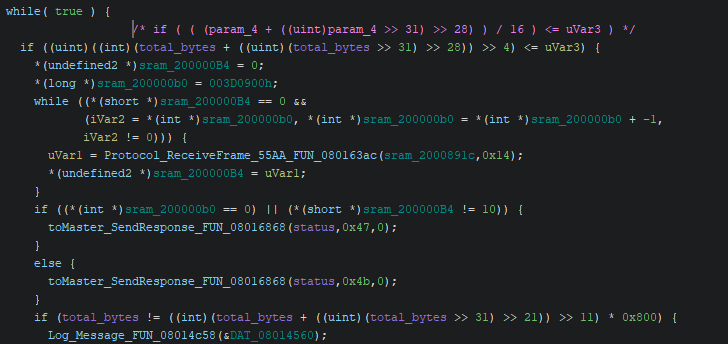

又STM32之vector table之0x0...4外, 0x00000000是Initial Main Stack，可能指向外部sram。以上兩者都必須有數值才能開始運作。 其餘則能設為隨機值或最大值以進入錯誤處理機制。

## 如何判讀 disassemble後 assembly正確與否


### 8051

8051的記憶體分為:
```
*   Program Memory(ROM): 4K(內部) or 64K(外部)
*   Data Memory(RAM): SFRs + 128 bits(內部) or 64K(外部)

SFRs: 特殊暫存器,如A(ACC),B,DPTR,Timer....
```





*   停擺待機 vs 硬體觸發

  Timer interrupt 會常用(臨時作動用, sleep()), delay則盡量避免 (wait())
   
    
```
 對於8051 (按byte順序 = 優先級排序):
  1.   0000  Reset(接著執行此指令)
  2.   0003  INT0 = External HW Interrupt 0
  3.   000B  TF0 = Timer 0 Interrupt
  4.   0013  INT1 = External HW Interrupt 1
  5.   001B  TF1 = Timer 1 Interrupt
  6.   0023  RI, TI = Serial Com Interrupt (讀or發訊號時最後一bit時拉起其中一flag,要考慮baud rate)

    另有一暫存器:IE Register = hex code能控制上述各interrupt要作動與否
    MOV IE, #81H    ; 使能外部中斷 INT0
```
*  CALL系列=副程式, 結束時需用RET回分支點
*  JUMP系列=直接跳轉, 用於LOOP或分支, 結束時用RETI, 常用
*  0000時多為JMP系列
*  想要防禦性編程的話多數指令會用MOV取代, 務必記得各個位置




note: AJMP 的opcode分別表示跳至Page0~7(= 00__到08__, 2K內), 後面hex則是low addr.


若資料都是在內部則純用MOV移動值,而若要訪問外部則要如下


```
90 00 37   MOV DPTR,#0x0037  ; 以DPTR指定起始外部addr.(or table位置)

# ROM (唯讀)
74 01     MOV A, #0x01   ; index=0x01
93       MOVC A, @A+DPTR   ; 從ROM讀取常數到A(from 0x0037+0x01)

# RAM
E0       MOVX A, @DPTR      ; 從外部0x0037載入數據到 A
    or
F0       MOVX @DPTR, A      ; 將 A 中的數據存入外部0x0037


```
其餘暫存器同理






多數INT觸發時會先 PUSH目前狀態入stack( PSW, ACC, B...)，最後在 RETI前 POP回來。根據會動到什麼做決定。



```
0000  75 D0 07  MOV SP, #07H             ; 初始化堆疊指標，SP = 07H(default)
0003  74 55     MOV A, #55H            ; 將數值 55H 加載到累加器 A
0005  78 33     MOV R0, #33H            ; 將數值 33H 加載到寄存器 R0
0007  79 77     MOV R1, #77H            ; 將數值 77H 加載到寄存器 R1

INT:
0009  C0 E0     PUSH ACC              ; 將累加器 A (55H) 壓入堆疊(08H)
000B  C0 00     PUSH 0               ; 將 R0 (33H) 壓入堆疊(09H)
000D  C0 01     PUSH 1               ; 將 R1 (77H) 壓入堆疊(0AH)

000F  E4        CLR A                    ; 清除累加器，模擬數據丟失
0010  78 00     MOV R0, #00H           ; 清除 R0
0012  79 00     MOV R1, #00H           ; 清除 R1

0014  D0 01     POP 1               ; 從堆疊彈出數據 (77H) 恢復到 R1
0016  D0 00     POP 0               ; 從堆疊彈出數據 (33H) 恢復到 R0
0018  D0 E0     POP ACC              ; 從堆疊彈出數據 (55H) 恢復到累加器 A

```




https://ebooks.inflibnet.ac.in/csp13/chapter/interrupt-handling-and-assembly-programming/

# 自 hex strings 變換出符合 assembly架構之 .bin  

input: .csv .xlsx ； output: .bin .xlsx

### 情形描述:

刪去無用bits後資料結構如下， 不按序且有時一組不足3行
```
0000,0001h ?
98,31,47,59,f0
98,65,9b,6c,f9
98,6f,bb,c0,01

0002,0003h ?
98,20,1d,13,07
98,01,fd,3d,ba
98,6f,bb,c0,02

98,3c,cc,27,e1
98,1d,c0,c6,8d
98,6f,bb,c0,02

```
update:

根據FDTI模擬燒錄的測試結果，確認前兩行8 bytes當下皆有燒錄進去，第三行僅會在6f,bb,c/d/e/f 中。

## import & universal func.


In [ ]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
import itertools

In [ ]:
def read_data(file_path, col_index=None, slice_tuple=None, concat=True):
    """
    Reads data from an Excel or CSV file with optional column selection or binary slicing.

    Args:
        file_path (str): Path to the file.
        col_index (int, optional): Index of the column to extract. Defaults to None.
        slice_tuple (tuple, optional): Binary slicing range (start, end). Defaults to None.
        concat (bool, optional): Whether to concatenate sliced row data or keep them separate. Defaults to True.

    Returns:
        list: Processed data. (list of lists)
    """
    #print(f"Processing file: {file_path}")

    # Read file
    if str(file_path).endswith('.xlsx'):
        df = pd.read_excel(file_path, header=None, dtype=str)
    else:  # Assume .csv
        df = pd.read_csv(file_path, header=None, dtype=str)

    # Preprocess: Uppercase, fill to byte size and remove empty values
    df = df.map(lambda x: str(x).strip().upper().zfill(2) if pd.notna(x) else '')

    if col_index is not None:
        return df.iloc[:, col_index].tolist()

    if slice_tuple:
        row_data = []
        for row in df.values:
            hex_row = ''.join(filter(None, row))
            if concat is True:
                row_data.extend(binary_filter(hex_row, slice_tuple))
            else:
                row_data.append(binary_filter(hex_row, slice_tuple))
        return row_data

    return df.values.tolist()


def binary_filter(hex_data, slice_tuples=None):
    """
    Converts hexadecimal data to binary, applies optional slicing, and converts back to a hex list.

    Args:
        hex_data (str or list): Hexadecimal data as a string or list of hex strings (e.g., ['A5', '5A']).
        slice_tuples (list of tuples or tuple, optional):
            Defines the start and end indices for slicing binary data.
            Can be a single tuple (start, end) or a list of tuples [(start1, end1), (start2, end2), ...].

    Returns:
        list: Hexadecimal representation of the filtered binary data (e.g., ['5A', 'A5']). Will fill '0' at very left
            if not a multiple of 8 in slice.
    """
    # If hex_data is a list, combine it into a single string
    if isinstance(hex_data, list):
        hex_data = ''.join(hex_data)

    # Convert hex to binary ste
    binary = ''.join(format(int(hex_data[i:i + 2], 16), '08b') for i in range(0, len(hex_data), 2))

    if slice_tuples:
        combined_binary = ''
        # Check if slice_tuples is a list of tuples or just a single tuple
        if isinstance(slice_tuples[0], tuple):
            for (start, end) in slice_tuples:
                combined_binary += binary[start:end]
        else:
            start, end = slice_tuples
            combined_binary = binary[start:end]   # single tuple

        binary = combined_binary

    # Convert back to hex list
    binary = binary.zfill((len(binary) + 7) // 8 * 8)  # 左側補零至 8 的倍數
    hex_result = [f"{int(binary[i:i + 8], 2):02X}" for i in range(0, len(binary), 8)]
    return hex_result


def save_results(results, base_name, output_folder, output_format='bin', single_output=False):
    """
    Saves matched results to files in the specified format.

    Args:
        results (list): List of matching data segments.
        base_name (str): Original file name without extension.
        output_folder (str): Path to the output folder.
        output_format (str, optional): Format to save files ('bin' or 'xlsx'). Defaults to 'bin'.
        single_output (bool, optional): If True, saves all results to a single file. Defaults to False.
    """
    # 確保輸出資料夾存在
    Path(output_folder).mkdir(parents=True, exist_ok=True)

    def save_to_bin(file_path, hex_data):
        """Helper function to save data in binary format."""
        if isinstance(hex_data[0], list):
            # flatten list of lists
            hex_data = [item for sublist in hex_data for item in sublist]

        with open(file_path, 'wb') as f:
            byte_data = bytes.fromhex(''.join(hex_data))
            f.write(byte_data)

    def save_to_excel(file_path, data):
        """Helper function to save data in Excel format."""
        # 如果是單一列表，轉換為列向量
        if isinstance(data[0], str):
            df = pd.DataFrame([data]).T
        else:
            df = pd.DataFrame(data)
        df.to_excel(file_path, index=False, header=False)

    # 判斷是否為單一輸出模式或簡單的字符串列表
    if single_output or all(isinstance(item, str) for item in results):
        file_prefix = base_name
        output_path = os.path.join(output_folder, f"{file_prefix}.{output_format}")

        if output_format == 'bin':
            if isinstance(results[0], list):
                # flatten list of lists
                results = [item for sublist in results for item in sublist]
            save_to_bin(output_path, results)

        elif output_format == 'xlsx':
            save_to_excel(output_path, results)
        return

    # 輸出多檔案的情況
    for i, data in enumerate(results):
        file_prefix = f"{base_name}_{i}"
        output_path = os.path.join(output_folder, f"{file_prefix}.{output_format}")

        if output_format == 'bin':
            save_to_bin(output_path, data)
        elif output_format == 'xlsx':
            save_to_excel(output_path, data)

In [ ]:
def xor(data, hex_value):
    '''XORs two hexadecimal str values'''
    return format((int(data, 16) ^ int(hex_value, 16)), '02X')


def rotation(input, left_shift_val=0, to_number=True, reverse=False):
    '''
    input: str
    left_shift_val: int
    to_number: bool
    reverse: bool

    return: 4 bytes hex string / 1 decimal
    '''
    length = 32  # bits
    left_shift_val = left_shift_val % length
    input_value = int(''.join(input), 16)

    if reverse is True:
        shifted_value = ((input_value << (length - left_shift_val)) | (input_value >> left_shift_val))  # right rotate
    else:
        shifted_value = ((input_value << left_shift_val) | (input_value >> (length - left_shift_val)))  # left rotate

    shifted_str = format(shifted_value, '08X')  # 32 bits
    return shifted_value if to_number is True else [shifted_str[idx:idx+2] for idx in range(0, len(shifted_str), 2)]


def get_permutations(k):
    """
    Generates all permutations of numbers from 0 to k-1.
    Returns:
      list: k! lists are inside
    """
    return list(itertools.permutations(range(k)))


def get_slice_combinations(total_len, k):
    output= []
    indices_list = list(itertools.combinations(list(range(total_len)), k))
    for indices in indices_list:
        output.append([(idx, idx+1) for idx in indices])

    return output

In [ ]:
def to_byte(input, input_format='bin_str'):
    """
    Convert data to hexadecimal format.(不成8的末位會補0)
    'bin_str':
    ['0','0'...] or ['0...',..] --> ['0x??',..] -> ['??',..]
    'decimal_32bits':


    """
    if input_format == 'bin_str':
        bin_str = ''.join(list(input))
        bits_list = [bin_str[i:i+8].ljust(8, '0') for i in range(0, len(bin_str), 8)]
        return [hex(int(bits, 2))[2:].zfill(2).upper() for bits in bits_list]

    elif input_format == 'decimal_32bits':
        hex_string = format(input & 0xFFFFFFFF, '08X')
        return [hex_string[i:i+2] for i in range(0, len(hex_string), 2)]

    else:
        raise ValueError('Unsupport Format')


def convert_to_binary(input):
    """
    Convert hex str to binary form
    ['0a',..] -> ['0000...',...] -> ['0','0',...]
    """
    # Ensure input is treated as a list of strings and strip whitespace
    if isinstance(input, str):
        input = [input.strip()]
    else:
        input = [item.strip() for item in input]

    int_data = [int(hex_num, 16) for hex_num in input if pd.notna(hex_num)]
    binary_list = [bin(num)[2:].zfill(8) for num in int_data]
    return [char for binary_string in binary_list for char in binary_string]


def flatten_str_list(data_list):
    '''flatten the list'''
    return [item for sublist in data_list for item in (flatten_str_list(sublist) if isinstance(sublist, list) else [sublist])]


def rearrange_array(input_list, input_len=None, byte_order=None, bit_order=None, custom_order=None, reverse=False, xor_val=None):
    """
    Rearranges hex list in the input_list based on byte_order, bit_order, or custom_order.

    Args:
        input_list: List of elements   (e.g., list of bytes or hex strings).
        input_len: Length of each element in bytes  (defaults to length of first element).
        byte_order: Order to rearrange bytes in list   (ex. [2, 1, 0] for input_len=3).
        bit_order: Order to rearrange bits within each byte   ([0,...,7] is original order).
        custom_order: Order to rearrange all bits in input_list, needs to specify each bit.
        reverse: If True, reverses entire output order in byte.
        xor_val: If set, XORs each element with this value.

    Returns:
        List with rearranged data.
    """
    rearranged_list = []

    # Handle byte_order
    if byte_order:
        input_len = len(input_list[0]) if input_list and input_list[0] else None # Default to the length of the first element, handle empty input
        if input_len is None:
            return []


        if len(byte_order) != input_len:
            raise ValueError(f"byte_order:{byte_order} does not match input_len:{input_len}")

        input_list = [[item[i] for i in byte_order] for item in input_list]

    # Handle bit_order
    if bit_order:
        if len(bit_order) != 8:
            raise ValueError(f"bit_order:{bit_order} is not a valid byte size")

        for item in input_list:
            # Convert hex string to binary, rearrange bits, and convert back to bytes
            binary_data = convert_to_binary(item)
            rearranged_binary = [
                binary_data[k + i]
                for k in range(0, len(binary_data), 8)
                for i in bit_order
            ]

            rearranged_list.append(to_byte(rearranged_binary))

    elif custom_order:
        for idx, item in enumerate(input_list):
            if len(item) * 8  != len(custom_order):
                raise ValueError(f"Element at index {idx} has a length different from custom_order")

            rearranged_binary = [item[i] for i in custom_order]
            rearranged_list.append(to_byte(rearranged_binary))

    else:
        rearranged_list = input_list

    output_list = flatten_str_list(rearranged_list)  # flatten

    if reverse:
        output_list = output_list[::-1]

    if xor_val:
        output_list = [xor(item, xor_val) for item in output_list]

    return output_list

In [ ]:
def run_length_extraction(data_list, bit_count=None, byte_length=1):
    '''
    Args:
        data_list (list): 輸入資料列表，每個元素為一個十六進制字符串。
        bit_count (int, optional): 運行長度字段的位數。默認為 None。
        byte_length (int, optional): 要提取的數據字節長度。默認為 1。

    Returns:
        list: 提取出的數據列表，每個元素為一個字節長度的十六進制字符串列表。
    '''
    output = []
    for data in data_list:
        run_length = int(''.join(binary_filter(data, (0, bit_count))), 16)
        byte_data = binary_filter(data, (bit_count + run_length, bit_count + run_length + byte_length*8))
        if bit_count + run_length + byte_length*8 > len(data) * 8:
            raise ValueError(f'Warning! Exceed input list length in run_length slice process')

        output.append(byte_data)

    return output

In [ ]:
def calculate_crc16(input_string, poly_hex='1021', initial_value='FFFF', output_xor='FFFF', rev_in=True, rev_out=True):
    data = bytes.fromhex(input_string) # must in hex format
    poly = int(poly_hex, 16)
    crc = int(initial_value, 16)

    for byte in data:
        if rev_in:
            byte = int('{:08b}'.format(byte)[::-1], 2)  # bit reverse

        crc ^= byte << 8
        for _ in range(8):
            if crc & 0x8000:
                crc = ((crc << 1) ^ poly) & 0xFFFF
            else:
                crc = (crc << 1) & 0xFFFF

    if rev_out:
        crc = int('{:016b}'.format(crc)[::-1], 2)   # bit reverse

    crc ^= int(output_xor, 16)
    return f'{crc:04X}'

## 1. Search possible .asm
assume: consecutive, sparse blocks, write-in 1 or more bytes, maybe reordered


### Gemini API輔助判定INT合理性
is_valid_interrupt(hex_list) 回傳判斷為true的list index，全無則回傳 [number of lists]

In [ ]:
# openai 暫時有bug
import google.generativeai as genai
from google.colab import userdata
from google.ai.generativelanguage_v1beta.types import content

genai.configure(api_key = userdata.get('GOOGLE_API_KEY'))

In [ ]:
# Create the model
generation_config = {
  "temperature": 0.25,
  "top_p": 0.35,
  "top_k": 40,
  "max_output_tokens": 8192,
  "response_schema": content.Schema(
    type = content.Type.OBJECT,
    properties = {
      "response": content.Schema(
        type = content.Type.ARRAY,
        items = content.Schema(
          type = content.Type.NUMBER,
        ),
      ),
    },
  ),
  "response_mime_type": "application/json",
}

model = genai.GenerativeModel(
  model_name="gemini-2.0-flash-exp",
  generation_config=generation_config,
)

chat_session = model.start_chat(
  history=[
    {
      "role": "user",
      "parts": [
        "先記好我等下給的dictionary，那是8051 opcode.",
      ],
    },
    {
      "role": "model",
      "parts": [
        "好的，我準備好了。請您提供 8051 的 opcode 字典，我會先記下來。您隨時可以給我。\n",
      ],
    },
    {
      "role": "user",
      "parts": [
        "{\n\"00\": {\"bytes\": 1, \"instruction\": \"NOP\"},\n\"01\": {\"bytes\": 2, \"instruction\": \"AJMP addr11\"},\n\"02\": {\"bytes\": 3, \"instruction\": \"LJMP addr16\"},\n\"03\": {\"bytes\": 1, \"instruction\": \"RR A\"},\n\"04\": {\"bytes\": 1, \"instruction\": \"INC A\"},\n\"05\": {\"bytes\": 2, \"instruction\": \"INC direct\"},\n\"06\": {\"bytes\": 1, \"instruction\": \"INC @R0\"},\n\"07\": {\"bytes\": 1, \"instruction\": \"INC @R1\"},\n\"08\": {\"bytes\": 1, \"instruction\": \"INC R0\"},\n\"09\": {\"bytes\": 1, \"instruction\": \"INC R1\"},\n\"0A\": {\"bytes\": 1, \"instruction\": \"INC R2\"},\n\"0B\": {\"bytes\": 1, \"instruction\": \"INC R3\"},\n\"0C\": {\"bytes\": 1, \"instruction\": \"INC R4\"},\n\"0D\": {\"bytes\": 1, \"instruction\": \"INC R5\"},\n\"0E\": {\"bytes\": 1, \"instruction\": \"INC R6\"},\n\"0F\": {\"bytes\": 1, \"instruction\": \"INC R7\"},\n\"10\": {\"bytes\": 3, \"instruction\": \"JBC bit, offset\"},\n\"11\": {\"bytes\": 2, \"instruction\": \"ACALL addr11\"},\n\"12\": {\"bytes\": 3, \"instruction\": \"LCALL addr16\"},\n\"13\": {\"bytes\": 1, \"instruction\": \"RRC A\"},\n\"14\": {\"bytes\": 1, \"instruction\": \"DEC A\"},\n\"15\": {\"bytes\": 2, \"instruction\": \"DEC direct\"},\n\"16\": {\"bytes\": 1, \"instruction\": \"DEC @R0\"},\n\"17\": {\"bytes\": 1, \"instruction\": \"DEC @R1\"},\n\"18\": {\"bytes\": 1, \"instruction\": \"DEC R0\"},\n\"19\": {\"bytes\": 1, \"instruction\": \"DEC R1\"},\n\"1A\": {\"bytes\": 1, \"instruction\": \"DEC R2\"},\n\"1B\": {\"bytes\": 1, \"instruction\": \"DEC R3\"},\n\"1C\": {\"bytes\": 1, \"instruction\": \"DEC R4\"},\n\"1D\": {\"bytes\": 1, \"instruction\": \"DEC R5\"},\n\"1E\": {\"bytes\": 1, \"instruction\": \"DEC R6\"},\n\"1F\": {\"bytes\": 1, \"instruction\": \"DEC R7\"},\n\"20\": {\"bytes\": 3, \"instruction\": \"JB bit, offset\"},\n\"21\": {\"bytes\": 2, \"instruction\": \"AJMP addr11\"},\n\"22\": {\"bytes\": 1, \"instruction\": \"RET\"},\n\"23\": {\"bytes\": 1, \"instruction\": \"RL A\"},\n\"24\": {\"bytes\": 2, \"instruction\": \"ADD A, #immed\"},\n\"25\": {\"bytes\": 2, \"instruction\": \"ADD A, direct\"},\n\"26\": {\"bytes\": 1, \"instruction\": \"ADD A, @R0\"},\n\"27\": {\"bytes\": 1, \"instruction\": \"ADD A, @R1\"},\n\"28\": {\"bytes\": 1, \"instruction\": \"ADD A, R0\"},\n\"29\": {\"bytes\": 1, \"instruction\": \"ADD A, R1\"},\n\"2A\": {\"bytes\": 1, \"instruction\": \"ADD A, R2\"},\n\"2B\": {\"bytes\": 1, \"instruction\": \"ADD A, R3\"},\n\"2C\": {\"bytes\": 1, \"instruction\": \"ADD A, R4\"},\n\"2D\": {\"bytes\": 1, \"instruction\": \"ADD A, R5\"},\n\"2E\": {\"bytes\": 1, \"instruction\": \"ADD A, R6\"},\n\"2F\": {\"bytes\": 1, \"instruction\": \"ADD A, R7\"},\n\"30\": {\"bytes\": 3, \"instruction\": \"JNB bit, offset\"},\n\"31\": {\"bytes\": 2, \"instruction\": \"ACALL addr11\"},\n\"32\": {\"bytes\": 1, \"instruction\": \"RETI\"},\n\"33\": {\"bytes\": 1, \"instruction\": \"RLC A\"},\n\"34\": {\"bytes\": 2, \"instruction\": \"ADDC A, #immed\"},\n\"35\": {\"bytes\": 2, \"instruction\": \"ADDC A, direct\"},\n\"36\": {\"bytes\": 1, \"instruction\": \"ADDC A, @R0\"},\n\"37\": {\"bytes\": 1, \"instruction\": \"ADDC A, @R1\"},\n\"38\": {\"bytes\": 1, \"instruction\": \"ADDC A, R0\"},\n\"39\": {\"bytes\": 1, \"instruction\": \"ADDC A, R1\"},\n\"3A\": {\"bytes\": 1, \"instruction\": \"ADDC A, R2\"},\n\"3B\": {\"bytes\": 1, \"instruction\": \"ADDC A, R3\"},\n\"3C\": {\"bytes\": 1, \"instruction\": \"ADDC A, R4\"},\n\"3D\": {\"bytes\": 1, \"instruction\": \"ADDC A, R5\"},\n\"3E\": {\"bytes\": 1, \"instruction\": \"ADDC A, R6\"},\n\"3F\": {\"bytes\": 1, \"instruction\": \"ADDC A, R7\"},\n\"40\": {\"bytes\": 2, \"instruction\": \"JC offset\"},\n\"41\": {\"bytes\": 2, \"instruction\": \"AJMP addr11\"},\n\"42\": {\"bytes\": 2, \"instruction\": \"ORL direct, A\"},\n\"43\": {\"bytes\": 3, \"instruction\": \"ORL direct, #immed\"},\n\"44\": {\"bytes\": 2, \"instruction\": \"ORL A, #immed\"},\n\"45\": {\"bytes\": 2, \"instruction\": \"ORL A, direct\"},\n\"46\": {\"bytes\": 1, \"instruction\": \"ORL A, @R0\"},\n\"47\": {\"bytes\": 1, \"instruction\": \"ORL A, @R1\"},\n\"48\": {\"bytes\": 1, \"instruction\": \"ORL A, R0\"},\n\"49\": {\"bytes\": 1, \"instruction\": \"ORL A, R1\"},\n\"4A\": {\"bytes\": 1, \"instruction\": \"ORL A, R2\"},\n\"4B\": {\"bytes\": 1, \"instruction\": \"ORL A, R3\"},\n\"4C\": {\"bytes\": 1, \"instruction\": \"ORL A, R4\"},\n\"4D\": {\"bytes\": 1, \"instruction\": \"ORL A, R5\"},\n\"4E\": {\"bytes\": 1, \"instruction\": \"ORL A, R6\"},\n\"4F\": {\"bytes\": 1, \"instruction\": \"ORL A, R7\"},\n\"50\": {\"bytes\": 2, \"instruction\": \"JNC offset\"},\n\"51\": {\"bytes\": 2, \"instruction\": \"ACALL addr11\"},\n\"52\": {\"bytes\": 2, \"instruction\": \"ANL direct, A\"},\n\"53\": {\"bytes\": 3, \"instruction\": \"ANL direct, #immed\"},\n\"54\": {\"bytes\": 2, \"instruction\": \"ANL A, #immed\"},\n\"55\": {\"bytes\": 2, \"instruction\": \"ANL A, direct\"},\n\"56\": {\"bytes\": 1, \"instruction\": \"ANL A, @R0\"},\n\"57\": {\"bytes\": 1, \"instruction\": \"ANL A, @R1\"},\n\"58\": {\"bytes\": 1, \"instruction\": \"ANL A, R0\"},\n\"59\": {\"bytes\": 1, \"instruction\": \"ANL A, R1\"},\n\"5A\": {\"bytes\": 1, \"instruction\": \"ANL A, R2\"},\n\"5B\": {\"bytes\": 1, \"instruction\": \"ANL A, R3\"},\n\"5C\": {\"bytes\": 1, \"instruction\": \"ANL A, R4\"},\n\"5D\": {\"bytes\": 1, \"instruction\": \"ANL A, R5\"},\n\"5E\": {\"bytes\": 1, \"instruction\": \"ANL A, R6\"},\n\"5F\": {\"bytes\": 1, \"instruction\": \"ANL A, R7\"},\n\"60\": {\"bytes\": 2, \"instruction\": \"JZ offset\"},\n\"61\": {\"bytes\": 2, \"instruction\": \"AJMP addr11\"},\n\"62\": {\"bytes\": 2, \"instruction\": \"XRL direct, A\"},\n\"63\": {\"bytes\": 3, \"instruction\": \"XRL direct, #immed\"},\n\"64\": {\"bytes\": 2, \"instruction\": \"XRL A, #immed\"},\n\"65\": {\"bytes\": 2, \"instruction\": \"XRL A, direct\"},\n\"66\": {\"bytes\": 1, \"instruction\": \"XRL A, @R0\"},\n\"67\": {\"bytes\": 1, \"instruction\": \"XRL A, @R1\"},\n\"68\": {\"bytes\": 1, \"instruction\": \"XRL A, R0\"},\n\"69\": {\"bytes\": 1, \"instruction\": \"XRL A, R1\"},\n\"6A\": {\"bytes\": 1, \"instruction\": \"XRL A, R2\"},\n\"6B\": {\"bytes\": 1, \"instruction\": \"XRL A, R3\"},\n\"6C\": {\"bytes\": 1, \"instruction\": \"XRL A, R4\"},\n\"6D\": {\"bytes\": 1, \"instruction\": \"XRL A, R5\"},\n\"6E\": {\"bytes\": 1, \"instruction\": \"XRL A, R6\"},\n\"6F\": {\"bytes\": 1, \"instruction\": \"XRL A, R7\"},\n\"70\": {\"bytes\": 2, \"instruction\": \"JNZ offset\"},\n\"71\": {\"bytes\": 2, \"instruction\": \"ACALL addr11\"},\n\"72\": {\"bytes\": 2, \"instruction\": \"ORL C, bit\"},\n\"73\": {\"bytes\": 1, \"instruction\": \"JMP @A+DPTR\"},\n\"74\": {\"bytes\": 2, \"instruction\": \"MOV A, #immed\"},\n\"75\": {\"bytes\": 3, \"instruction\": \"MOV direct, #immed\"},\n\"76\": {\"bytes\": 2, \"instruction\": \"MOV @R0, #immed\"},\n\"77\": {\"bytes\": 2, \"instruction\": \"MOV @R1, #immed\"},\n\"78\": {\"bytes\": 2, \"instruction\": \"MOV R0, #immed\"},\n\"79\": {\"bytes\": 2, \"instruction\": \"MOV R1, #immed\"},\n\"7A\": {\"bytes\": 2, \"instruction\": \"MOV R2, #immed\"},\n\"7B\": {\"bytes\": 2, \"instruction\": \"MOV R3, #immed\"},\n\"7C\": {\"bytes\": 2, \"instruction\": \"MOV R4, #immed\"},\n\"7D\": {\"bytes\": 2, \"instruction\": \"MOV R5, #immed\"},\n\"7E\": {\"bytes\": 2, \"instruction\": \"MOV R6, #immed\"},\n\"7F\": {\"bytes\": 2, \"instruction\": \"MOV R7, #immed\"},\n\"80\": {\"bytes\": 2, \"instruction\": \"SJMP offset\"},\n\"81\": {\"bytes\": 2, \"instruction\": \"AJMP addr11\"},\n\"82\": {\"bytes\": 2, \"instruction\": \"ANL C, bit\"},\n\"83\": {\"bytes\": 1, \"instruction\": \"MOVC A, @A+PC\"},\n\"84\": {\"bytes\": 1, \"instruction\": \"DIV AB\"},\n\"85\": {\"bytes\": 3, \"instruction\": \"MOV direct, direct\"},\n\"86\": {\"bytes\": 2, \"instruction\": \"MOV direct, @R0\"},\n\"87\": {\"bytes\": 2, \"instruction\": \"MOV direct, @R1\"},\n\"88\": {\"bytes\": 2, \"instruction\": \"MOV direct, R0\"},\n\"89\": {\"bytes\": 2, \"instruction\": \"MOV direct, R1\"},\n\"8A\": {\"bytes\": 2, \"instruction\": \"MOV direct, R2\"},\n\"8B\": {\"bytes\": 2, \"instruction\": \"MOV direct, R3\"},\n\"8C\": {\"bytes\": 2, \"instruction\": \"MOV direct, R4\"},\n\"8D\": {\"bytes\": 2, \"instruction\": \"MOV direct, R5\"},\n\"8E\": {\"bytes\": 2, \"instruction\": \"MOV direct, R6\"},\n\"8F\": {\"bytes\": 2, \"instruction\": \"MOV direct, R7\"},\n\"90\": {\"bytes\": 3, \"instruction\": \"MOV DPTR, #immed\"},\n\"91\": {\"bytes\": 2, \"instruction\": \"ACALL addr11\"},\n\"92\": {\"bytes\": 2, \"instruction\": \"MOV bit, C\"},\n\"93\": {\"bytes\": 1, \"instruction\": \"MOVC A, @A+DPTR\"},\n\"94\": {\"bytes\": 2, \"instruction\": \"SUBB A, #immed\"},\n\"95\": {\"bytes\": 2, \"instruction\": \"SUBB A, direct\"},\n\"96\": {\"bytes\": 1, \"instruction\": \"SUBB A, @R0\"},\n\"97\": {\"bytes\": 1, \"instruction\": \"SUBB A, @R1\"},\n\"98\": {\"bytes\": 1, \"instruction\": \"SUBB A, R0\"},\n\"99\": {\"bytes\": 1, \"instruction\": \"SUBB A, R1\"},\n\"9A\": {\"bytes\": 1, \"instruction\": \"SUBB A, R2\"},\n\"9B\": {\"bytes\": 1, \"instruction\": \"SUBB A, R3\"},\n\"9C\": {\"bytes\": 1, \"instruction\": \"SUBB A, R4\"},\n\"9D\": {\"bytes\": 1, \"instruction\": \"SUBB A, R5\"},\n\"9E\": {\"bytes\": 1, \"instruction\": \"SUBB A, R6\"},\n\"9F\": {\"bytes\": 1, \"instruction\": \"SUBB A, R7\"},\n\"A0\": {\"bytes\": 2, \"instruction\": \"ORL C, /bit\"},\n\"A1\": {\"bytes\": 2, \"instruction\": \"AJMP addr11\"},\n\"A2\": {\"bytes\": 2, \"instruction\": \"MOV C, bit\"},\n\"A3\": {\"bytes\": 1, \"instruction\": \"INC DPTR\"},\n\"A4\": {\"bytes\": 1, \"instruction\": \"MUL AB\"},\n\"A5\": {\"bytes\": 0, \"instruction\": \"reserved\"},\n\"A6\": {\"bytes\": 2, \"instruction\": \"MOV @R0, direct\"},\n\"A7\": {\"bytes\": 2, \"instruction\": \"MOV @R1, direct\"},\n\"A8\": {\"bytes\": 2, \"instruction\": \"MOV R0, direct\"},\n\"A9\": {\"bytes\": 2, \"instruction\": \"MOV R1, direct\"},\n\"AA\": {\"bytes\": 2, \"instruction\": \"MOV R2, direct\"},\n\"AB\": {\"bytes\": 2, \"instruction\": \"MOV R3, direct\"},\n\"AC\": {\"bytes\": 2, \"instruction\": \"MOV R4, direct\"},\n\"AD\": {\"bytes\": 2, \"instruction\": \"MOV R5, direct\"},\n\"AE\": {\"bytes\": 2, \"instruction\": \"MOV R6, direct\"},\n\"AF\": {\"bytes\": 2, \"instruction\": \"MOV R7, direct\"},\n\"B0\": {\"bytes\": 2, \"instruction\": \"ANL C, /bit\"},\n\"B1\": {\"bytes\": 2, \"instruction\": \"ACALL addr11\"},\n\"B2\": {\"bytes\": 2, \"instruction\": \"CPL bit\"},\n\"B3\": {\"bytes\": 1, \"instruction\": \"CPL C\"},\n\"B4\": {\"bytes\": 3, \"instruction\": \"CJNE A, #immed, offset\"},\n\"B5\": {\"bytes\": 3, \"instruction\": \"CJNE A, direct, offset\"},\n\"B6\": {\"bytes\": 3, \"instruction\": \"CJNE @R0, #immed, offset\"},\n\"B7\": {\"bytes\": 3, \"instruction\": \"CJNE @R1, #immed, offset\"},\n\"B8\": {\"bytes\": 3, \"instruction\": \"CJNE R0, #immed, offset\"},\n\"B9\": {\"bytes\": 3, \"instruction\": \"CJNE R1, #immed, offset\"},\n\"BA\": {\"bytes\": 3, \"instruction\": \"CJNE R2, #immed, offset\"},\n\"BB\": {\"bytes\": 3, \"instruction\": \"CJNE R3, #immed, offset\"},\n\"BC\": {\"bytes\": 3, \"instruction\": \"CJNE R4, #immed, offset\"},\n\"BD\": {\"bytes\": 3, \"instruction\": \"CJNE R5, #immed, offset\"},\n\"BE\": {\"bytes\": 3, \"instruction\": \"CJNE R6, #immed, offset\"},\n\"BF\": {\"bytes\": 3, \"instruction\": \"CJNE R7, #immed, offset\"},\n\"C0\": {\"bytes\": 2, \"instruction\": \"PUSH direct\"},\n\"C1\": {\"bytes\": 2, \"instruction\": \"AJMP addr11\"},\n\"C2\": {\"bytes\": 2, \"instruction\": \"CLR bit\"},\n\"C3\": {\"bytes\": 1, \"instruction\": \"CLR C\"},\n\"C4\": {\"bytes\": 1, \"instruction\": \"SWAP A\"},\n\"C5\": {\"bytes\": 2, \"instruction\": \"XCH A, direct\"},\n\"C6\": {\"bytes\": 1, \"instruction\": \"XCH A, @R0\"},\n\"C7\": {\"bytes\": 1, \"instruction\": \"XCH A, @R1\"},\n\"C8\": {\"bytes\": 1, \"instruction\": \"XCH A, R0\"},\n\"C9\": {\"bytes\": 1, \"instruction\": \"XCH A, R1\"},\n\"CA\": {\"bytes\": 1, \"instruction\": \"XCH A, R2\"},\n\"CB\": {\"bytes\": 1, \"instruction\": \"XCH A, R3\"},\n\"CC\": {\"bytes\": 1, \"instruction\": \"XCH A, R4\"},\n\"CD\": {\"bytes\": 1, \"instruction\": \"XCH A, R5\"},\n\"CE\": {\"bytes\": 1, \"instruction\": \"XCH A, R6\"},\n\"CF\": {\"bytes\": 1, \"instruction\": \"XCH A, R7\"},\n\"D0\": {\"bytes\": 2, \"instruction\": \"POP direct\"},\n\"D1\": {\"bytes\": 2, \"instruction\": \"ACALL addr11\"},\n\"D2\": {\"bytes\": 2, \"instruction\": \"SETB bit\"},\n\"D3\": {\"bytes\": 1, \"instruction\": \"SETB C\"},\n\"D4\": {\"bytes\": 1, \"instruction\": \"DA A\"},\n\"D5\": {\"bytes\": 3, \"instruction\": \"DJNZ direct, offset\"},\n\"D6\": {\"bytes\": 1, \"instruction\": \"XCHD A, @R0\"},\n\"D7\": {\"bytes\": 1, \"instruction\": \"XCHD A, @R1\"},\n\"D8\": {\"bytes\": 2, \"instruction\": \"DJNZ R0, offset\"},\n\"D9\": {\"bytes\": 2, \"instruction\": \"DJNZ R1, offset\"},\n\"DA\": {\"bytes\": 2, \"instruction\": \"DJNZ R2, offset\"},\n\"DB\": {\"bytes\": 2, \"instruction\": \"DJNZ R3, offset\"},\n\"DC\": {\"bytes\": 2, \"instruction\": \"DJNZ R4, offset\"},\n\"DD\": {\"bytes\": 2, \"instruction\": \"DJNZ R5, offset\"},\n\"DE\": {\"bytes\": 2, \"instruction\": \"DJNZ R6, offset\"},\n\"DF\": {\"bytes\": 2, \"instruction\": \"DJNZ R7, offset\"},\n\"E0\": {\"bytes\": 1, \"instruction\": \"MOVX A, @DPTR\"},\n\"E1\": {\"bytes\": 2, \"instruction\": \"AJMP addr11\"},\n\"E2\": {\"bytes\": 1, \"instruction\": \"MOVX A, @R0\"},\n\"E3\": {\"bytes\": 1, \"instruction\": \"MOVX A, @R1\"},\n\"E4\": {\"bytes\": 1, \"instruction\": \"CLR A\"},\n\"E5\": {\"bytes\": 2, \"instruction\": \"MOV A, direct\"},\n\"E6\": {\"bytes\": 1, \"instruction\": \"MOV A, @R0\"},\n\"E7\": {\"bytes\": 1, \"instruction\": \"MOV A, @R1\"},\n\"E8\": {\"bytes\": 1, \"instruction\": \"MOV A, R0\"},\n\"E9\": {\"bytes\": 1, \"instruction\": \"MOV A, R1\"},\n\"EA\": {\"bytes\": 1, \"instruction\": \"MOV A, R2\"},\n\"EB\": {\"bytes\": 1, \"instruction\": \"MOV A, R3\"},\n\"EC\": {\"bytes\": 1, \"instruction\": \"MOV A, R4\"},\n\"ED\": {\"bytes\": 1, \"instruction\": \"MOV A, R5\"},\n\"EE\": {\"bytes\": 1, \"instruction\": \"MOV A, R6\"},\n\"EF\": {\"bytes\": 1, \"instruction\": \"MOV A, R7\"},\n\"F0\": {\"bytes\": 1, \"instruction\": \"MOVX @DPTR, A\"},\n\"F1\": {\"bytes\": 2, \"instruction\": \"ACALL addr11\"},\n\"F2\": {\"bytes\": 1, \"instruction\": \"MOVX @R0, A\"},\n\"F3\": {\"bytes\": 1, \"instruction\": \"MOVX @R1, A\"},\n\"F4\": {\"bytes\": 1, \"instruction\": \"CPL A\"},\n\"F5\": {\"bytes\": 2, \"instruction\": \"MOV direct, A\"},\n\"F6\": {\"bytes\": 1, \"instruction\": \"MOV @R0, A\"},\n\"F7\": {\"bytes\": 1, \"instruction\": \"MOV @R1, A\"},\n\"F8\": {\"bytes\": 1, \"instruction\": \"MOV R0, A\"},\n\"F9\": {\"bytes\": 1, \"instruction\": \"MOV R1, A\"},\n\"FA\": {\"bytes\": 1, \"instruction\": \"MOV R2, A\"},\n\"FB\": {\"bytes\": 1, \"instruction\": \"MOV R3, A\"},\n\"FC\": {\"bytes\": 1, \"instruction\": \"MOV R4, A\"},\n\"FD\": {\"bytes\": 1, \"instruction\": \"MOV R5, A\"},\n\"FE\": {\"bytes\": 1, \"instruction\": \"MOV R6, A\"},\n\"FF\": {\"bytes\": 1, \"instruction\": \"MOV R7, A\"}\n}",
      ],
    },
    {
      "role": "model",
      "parts": [
        "好的，我已經將您提供的 8051 opcode 字典記錄下來了。我會仔細記住每個 opcode 對應的指令和位元組數。\n\n現在我已經準備好接收您的指令，並可以用這個字典來協助您分析或處理 8051 的機器碼。\n",
      ],
    },
    {
      "role": "user",
      "parts": [
        "我打算做gemini based assembly helper,請務必遵守相關流程與dictionary的資料才不會有錯誤。\n\n當接收到hex string時將視為機器碼並在後台做以下流程:\n\n1. 確認指令集和操作碼長度\n8051 的指令有 1 到 3 個字節，第一個字節通常是操作碼 (Opcode)，接下來的字節是操作數 (Operand)。\n必須先了解 8051 指令集，對應 HEX 的操作碼和操作數。\n2. 分析 HEX 數據\n將 HEX 數據逐字節分段，識別每條指令的操作碼和其對應的操作數。\n3. 對照 8051 指令集\n將操作碼與 8051 指令集表匹配，找出對應的指令。\n根據指令的長度判定需要讀取多少操作數，也就是我提供的dictionary中的'bytes'數。\n4. 將數據翻譯成 Assembly\n將操作碼及操作數翻譯為對應的組合語言。\n\n重複以上步驟直到完成。\n\n假設有以下 HEX 數據：\n\n複製程式碼\n74 25 F5 00 02 00 10\nStep 1: 分段數據\n我們從第一個字節開始分析，逐條指令進行解讀。\n\n74 是操作碼，對應指令集中的 MOV A, #data（立即數傳到累加器）。\n\n下一個字節 25 是立即數。\n指令為：MOV A, #25H。\n接下來是 F5，對應指令 MOV direct, A（將累加器內容存入直接位址）。\n\n下一個字節 00 是 direct address。\n指令為：MOV 00H, A。\n再看 02，對應指令 LJMP addr16（絕對跳轉）。\n\n接下來兩個字節 00 10 是目標地址。\n指令為：LJMP 0010H。\nStep 2: 將其轉換為 Assembly\n翻譯完成的 Assembly 指令如下：\n \nMOV A, #25H        ; 將立即數 25H 傳送到累加器 A\nMOV 00H, A         ; 將 A 的內容存入直接位址 00H\nLJMP 0010H         ; 跳轉到絕對地址 0010H",
      ],
    },
    {
      "role": "model",
      "parts": [
        "好的，我完全理解您的需求。我會嚴格按照您描述的流程，並使用您提供的 8051 opcode 字典來解析 HEX 機器碼，並將其轉換為組合語言。\n\n**核心原則：**\n\n*   **嚴格遵守字典：** 我會完全依賴您提供的字典來查找 opcode 對應的指令和位元組數。\n*   **逐字節解析：** 我會從 HEX 字串的第一個字節開始，逐個字節地解析，並根據指令長度讀取後續的操作數。\n*   **精確翻譯：** 我會將 opcode 和操作數精確地翻譯成對應的組合語言指令。\n*   **逐步處理：** 我會重複這個過程，直到 HEX 字串完全被解析。\n\n**流程總結：**\n\n1.  **接收 HEX 字串：** 接收您提供的 HEX 機器碼字串。\n2.  **初始化：** 設定一個指標，指向 HEX 字串的起始位置。\n3.  **讀取 Opcode：** 從當前指標位置讀取一個字節，作為 opcode。\n4.  **查閱字典：** 在字典中查找該 opcode，獲取對應的指令和位元組數。\n5.  **讀取操作數：** 根據指令的位元組數，從 HEX 字串中讀取相應數量的操作數。\n6.  **翻譯指令：** 將 opcode 和操作數翻譯成組合語言指令。\n7.  **輸出指令：** 將翻譯後的組合語言指令輸出。\n8.  **更新指標：** 將指標移動到下一條指令的起始位置。\n9.  **重複：** 如果 HEX 字串尚未解析完畢，則回到步驟 3。\n10. **完成：** 當 HEX 字串解析完畢，則結束。\n\n**我已經準備好接收您的 HEX 字串了。請隨時提供，我會按照上述流程進行解析並翻譯成組合語言。**\n\n我會盡力確保翻譯的準確性，並在過程中保持嚴謹。\n",
      ],
    },
    {
      "role": "user",
      "parts": [
        "若有以下 HEX：\n\n複製程式碼\n12 00 20 E5 30 25 10\n解析過程\n12H → LCALL addr16\n\n後兩字節 00 20 是目標地址。\n組成：LCALL 0020H\nE5H → MOV A, direct\n\n下一字節 30H 是 direct address。\n組成：MOV A, 30H\n25H → ADD A, direct\n\n下一字節 10H 是 direct address。\n組成：ADD A, 10H\n\nAssembly:\n\nLCALL 0020H        ; 調用子程序地址 0020H\nMOV A, 30H         ; 將直接地址 30H 的值傳送到累加器 A\nADD A, 10H         ; 將直接地址 10H 的值加到累加器 A\n\n",
      ],
    },
    {
      "role": "model",
      "parts": [
        "好的，我理解了。您提供了一個新的 HEX 字串 `12 00 20 E5 30 25 10`，以及您期望的解析過程和最終的組合語言輸出。我會按照您提供的步驟，驗證我的理解是否正確，並確保我能夠正確處理類似的輸入。\n\n**解析過程驗證：**\n\n1.  **12H:** 查字典，找到 `LCALL addr16`，長度 3 bytes。\n2.  **00 20:** 讀取操作數，得到絕對地址 `0020H`。\n3.  **輸出：** `LCALL 0020H ; 調用子程序地址 0020H`\n4.  **E5H:** 查字典，找到 `MOV A, direct`，長度 2 bytes。\n5.  **30H:** 讀取操作數，得到直接地址 `30H`。\n6.  **輸出：** `MOV A, 30H ; 將直接地址 30H 的值傳送到累加器 A`\n7.  **25H:** 查字典，找到 `ADD A, direct`，長度 2 bytes。\n8.  **10H:** 讀取操作數，得到直接地址 `10H`。\n9.  **輸出：** `ADD A, 10H ; 將直接地址 10H 的值加到累加器 A`\n\n**最終輸出：**\n\n```assembly\nLCALL 0020H        ; 調用子程序地址 0020H\nMOV A, 30H         ; 將直接地址 30H 的值傳送到累加器 A\nADD A, 10H         ; 將直接地址 10H 的值加到累加器 A\n```\n\n**結論：**\n\n我完全理解了您提供的解析過程，並且能夠正確地將 HEX 字串轉換為組合語言。我會繼續按照這個流程處理您提供的任何 HEX 字串。\n\n**下一步：**\n\n請隨時提供您想要解析的 HEX 字串，我會按照您期望的方式進行處理，並輸出對應的組合語言。我已經準備好接收您的下一個輸入了。\n",
      ],
    },
    {
      "role": "user",
      "parts": [
        "90 00 35 e0 60 1b ff 04 f0 74 00 2f f5 82 e4 34 00 f5 83 e0 f5 99 90 00 35 e0 c3 94 06 40 02 e4 f0\n\n",
      ],
    },
    {
      "role": "model",
      "parts": [
        "好的，我收到了新的 HEX 字串：`90 00 35 e0 60 1b ff 04 f0 74 00 2f f5 82 e4 34 00 f5 83 e0 f5 99 90 00 35 e0 c3 94 06 40 02 e4 f0`。我將按照之前的流程，逐字節解析並轉換為組合語言。\n\n**解析過程：**\n\n1.  **90H:** 查字典，找到 `MOV DPTR, #immed`，長度 3 bytes。\n2.  **00 35:** 讀取操作數，得到立即數 `0035H`。\n3.  **輸出：** `MOV DPTR, #0035H`\n4.  **E0H:** 查字典，找到 `MOVX A, @DPTR`，長度 1 byte。\n5.  **輸出：** `MOVX A, @DPTR`\n6.  **60H:** 查字典，找到 `JZ offset`，長度 2 bytes。\n7.  **1BH:** 讀取操作數，得到偏移量 `1BH`。\n8.  **輸出：** `JZ 1BH`\n9.  **FFH:** 查字典，找到 `MOV R7, A`，長度 1 byte。\n10. **輸出：** `MOV R7, A`\n11. **04H:** 查字典，找到 `INC A`，長度 1 byte。\n12. **輸出：** `INC A`\n13. **F0H:** 查字典，找到 `MOVX @DPTR, A`，長度 1 byte。\n14. **輸出：** `MOVX @DPTR, A`\n15. **74H:** 查字典，找到 `MOV A, #immed`，長度 2 bytes。\n16. **00H:** 讀取操作數，得到立即數 `00H`。\n17. **輸出：** `MOV A, #00H`\n18. **2FH:** 查字典，找到 `ADD A, R7`，長度 1 byte。\n19. **輸出：** `ADD A, R7`\n20. **F5H:** 查字典，找到 `MOV direct, A`，長度 2 bytes。\n21. **82H:** 讀取操作數，得到直接地址 `82H`。\n22. **輸出：** `MOV 82H, A`\n23. **E4H:** 查字典，找到 `CLR A`，長度 1 byte。\n24. **輸出：** `CLR A`\n25. **34H:** 查字典，找到 `ADDC A, #immed`，長度 2 bytes。\n26. **00H:** 讀取操作數，得到立即數 `00H`。\n27. **輸出：** `ADDC A, #00H`\n28. **F5H:** 查字典，找到 `MOV direct, A`，長度 2 bytes。\n29. **83H:** 讀取操作數，得到直接地址 `83H`。\n30. **輸出：** `MOV 83H, A`\n31. **E0H:** 查字典，找到 `MOVX A, @DPTR`，長度 1 byte。\n32. **輸出：** `MOVX A, @DPTR`\n33. **F5H:** 查字典，找到 `MOV direct, A`，長度 2 bytes。\n34. **99H:** 讀取操作數，得到直接地址 `99H`。\n35. **輸出：** `MOV 99H, A`\n36. **90H:** 查字典，找到 `MOV DPTR, #immed`，長度 3 bytes。\n37. **00 35:** 讀取操作數，得到立即數 `0035H`。\n38. **輸出：** `MOV DPTR, #0035H`\n39. **E0H:** 查字典，找到 `MOVX A, @DPTR`，長度 1 byte。\n40. **輸出：** `MOVX A, @DPTR`\n41. **C3H:** 查字典，找到 `CLR C`，長度 1 byte。\n42. **輸出：** `CLR C`\n43. **94H:** 查字典，找到 `SUBB A, #immed`，長度 2 bytes。\n44. **06H:** 讀取操作數，得到立即數 `06H`。\n45. **輸出：** `SUBB A, #06H`\n46. **40H:** 查字典，找到 `JC offset`，長度 2 bytes。\n47. **02H:** 讀取操作數，得到偏移量 `02H`。\n48. **輸出：** `JC 02H`\n49. **E4H:** 查字典，找到 `CLR A`，長度 1 byte。\n50. **輸出：** `CLR A`\n51. **F0H:** 查字典，找到 `MOVX @DPTR, A`，長度 1 byte。\n52. **輸出：** `MOVX @DPTR, A`\n\n**組合語言輸出：**\n\n```assembly\nMOV DPTR, #0035H\nMOVX A, @DPTR\nJZ 1BH\nMOV R7, A\nINC A\nMOVX @DPTR, A\nMOV A, #00H\nADD A, R7\nMOV 82H, A\nCLR A\nADDC A, #00H\nMOV 83H, A\nMOVX A, @DPTR\nMOV 99H, A\nMOV DPTR, #0035H\nMOVX A, @DPTR\nCLR C\nSUBB A, #06H\nJC 02H\nCLR A\nMOVX @DPTR, A\n```\n\n**結論：**\n\n我已成功將您提供的 HEX 字串轉換為組合語言，並按照您提供的字典和流程進行了解析。請檢查輸出是否符合您的預期。我已準備好接收您的下一個 HEX 字串。\n",
      ],
    },
    {
      "role": "user",
      "parts": [
        "接著學習特殊功能暫存器=SFR的位置,他們在內部MEMORY中:\n \nP0    : 80H\nSP    : 81H\nDPL   : 82H\nDPH   : 83H\nPCON  : 87H\nTCON  : 88H\nTMOD  : 89H\nTL0   : 8AH\nTL1   : 8BH\nTH0   : 8CH\nTH1   : 8DH\nP1    : 90H\nSCON  : 98H\nSBUF  : 99H\nP2    : A0H\nIE    : A8H\nP3    : B0H\nIP    : B8H\nPSW   : D0H\nACC   : E0H\nB     : F0H\n\n\n其中opcode指的DPTR 是 數據指標（Data Pointer），由兩個 8 位元的暫存器組成：\nDPL（數據指標低位，地址 82H）\nDPH（數據指標高位，地址 83H） \n用於指向外部 RAM 或 ROM 的地址。 與外部存取指令（如 MOVX 或 MOVC）搭配使用.\n且PUSH,POP等opcode有 direct時這些address 請直接視為對這些sfr中的值作動。如:\n \n c0 e0           PUSH         A\n c0 f0           PUSH         B\nc0 83           PUSH         DPH\n c0 82           PUSH         DPL\nc0 d0           PUSH         PSW\n75 d0 08        MOV          PSW,#0x8\n90 00 29        MOV          DPTR,#0x29\ne0              MOVX         A,@DPTR=>DAT_EXTMEM_0\n 04              INC          A\n ",
      ],
    },
    {
      "role": "model",
      "parts": [
        "好的，我已經記錄下您提供的特殊功能暫存器 (SFR) 的地址，以及關於 DPTR 和 `PUSH`/`POP` 指令的特殊處理規則。我會將這些資訊整合到我的解析流程中。\n\n**SFR 地址：**\n\n我已經將以下 SFR 地址儲存起來，並會在解析過程中使用：\n\n*   `P0`: `80H`\n*   `SP`: `81H`\n*   `DPL`: `82H`\n*   `DPH`: `83H`\n*   `PCON`: `87H`\n*   `TCON`: `88H`\n*   `TMOD`: `89H`\n*   `TL0`: `8AH`\n*   `TL1`: `8BH`\n*   `TH0`: `8CH`\n*   `TH1`: `8DH`\n*   `P1`: `90H`\n*   `SCON`: `98H`\n*   `SBUF`: `99H`\n*   `P2`: `A0H`\n*   `IE`: `A8H`\n*   `P3`: `B0H`\n*   `IP`: `B8H`\n*   `PSW`: `D0H`\n*   `ACC`: `E0H`\n*   `B`: `F0H`\n\n**DPTR 的處理：**\n\n*   我理解 `DPTR` 是由 `DPL` (82H) 和 `DPH` (83H) 組成的 16 位元數據指標。\n*   當遇到 `MOV DPTR, #immed` 指令時，我會將後續的兩個字節組合成 16 位元的立即數，並將其視為 `DPTR` 的值。\n*   當遇到 `MOVX A, @DPTR` 或 `MOVX @DPTR, A` 指令時，我會將 `DPTR` 的值視為外部 RAM 或 ROM 的地址。\n\n**`PUSH`/`POP` 指令的處理：**\n\n*   當 `PUSH` 或 `POP` 指令的操作數是 `direct` 時，我會將該 `direct` 地址視為 SFR 的地址，並直接對應到 SFR 的名稱。例如：\n    *   `PUSH 82H` 會被翻譯為 `PUSH DPL`\n    *   `POP D0H` 會被翻譯為 `POP PSW`\n\n**範例解析驗證：**\n\n我會按照您提供的範例進行驗證，確保我理解了這些規則：\n\n*   `c0 e0`  => `PUSH ACC`\n*   `c0 f0`  => `PUSH B`\n*   `c0 83`  => `PUSH DPH`\n*   `c0 82`  => `PUSH DPL`\n*   `c0 d0`  => `PUSH PSW`\n*   `75 d0 08` => `MOV PSW, #08H`\n*   `90 00 29` => `MOV DPTR, #0029H`\n*   `e0`      => `MOVX A, @DPTR` (這裡我會註解為 `DAT_EXTMEM_0`，表示外部記憶體地址)\n*   `04`      => `INC A`\n\n**總結：**\n\n我已經完全理解了您提供的 SFR 地址、DPTR 的處理方式，以及 `PUSH`/`POP` 指令的特殊規則。我會將這些規則應用到我的解析流程中，並確保輸出正確的組合語言。\n\n**我已經準備好接收您的下一個 HEX 字串了。請隨時提供，我會按照更新後的規則進行解析。**\n",
      ],
    },
    {
      "role": "user",
      "parts": [
        "接著要學習如何將轉換出的assembly做判斷，看是否為外部中斷。\n\n外部中斷流程與分析\n觸發條件：\n\n外部中斷0（INT0）和外部中斷1（INT1）由TCON寄存器的IT0和IT1控制，支援邊沿觸發或電平觸發。\n執行需求：\n中斷旗標清除：在 ISR 內必須清除中斷觸發的旗標（IE0 或 IE1）。\n暫存器保存與恢復：僅保存與 ISR 中修改的暫存器\n\n需用到的特殊功能暫存器（SFR）說明：\n\n暫存器\t位址\t功能描述\nIE\tA8H\t控制中斷的啟用和關閉。EX0 和 EX1 分別控制外部中斷 0 和外部中斷 1 的使能。\nTCON\t88H\t包含外部中斷的觸發旗標與模式設定位：IE0 / IE1 表示觸發旗標，IT0 / IT1 設定觸發模式。\nPSW\tD0H\t程式狀態字，用於保存/恢復執行上下文。\n\n舉例EXT0_ISR:\nPUSH ACC          ; 保存累加器\nMOV A, COUNTER    ; 將計數器值讀入ACC\nINC A             ; 增加計數器\nMOV COUNTER, A    ; 將新值寫回計數器\nCLR IE0           ; 清除外部中斷0旗標\nPOP ACC           ; 恢復累加器\nRETI              ; 返回主程式\n\n舉例EXT1_ISR:\nPUSH ACC          ; 保存累加器\nJB P3.2, SKIP     ; 若P3.2為高電平，跳過\nSETB P1.0         ; 控制P1.0的輸出高電平\nSKIP:\nCLR IE1           ; 清除外部中斷1旗標\nPOP ACC           ; 恢復累加器\nRETI              ; 返回主程式",
      ],
    },
    {
      "role": "model",
      "parts": [
        "好的，我理解了您關於外部中斷流程和分析的需求。我會將這些資訊整合到我的解析流程中，以便能夠識別和分析外部中斷服務例程 (ISR)。\n\n**外部中斷流程重點：**\n\n1.  **觸發條件：**\n    *   外部中斷 0 (INT0) 和外部中斷 1 (INT1) 的觸發由 `TCON` 暫存器的 `IT0` 和 `IT1` 位元控制，可以是邊緣觸發或電平觸發。\n    *   中斷觸發後，`TCON` 暫存器的 `IE0` 或 `IE1` 位元會被設定。\n2.  **執行需求：**\n    *   **中斷旗標清除：** 在 ISR 內，必須清除 `TCON` 暫存器中對應的中斷觸發旗標 (`IE0` 或 `IE1`)。\n    *   **暫存器保存與恢復：** ISR 應該保存它修改的暫存器，並在返回前恢復它們。通常會使用 `PUSH` 和 `POP` 指令來實現。\n3.  **相關 SFR：**\n    *   `IE` (A8H): 中斷使能暫存器，`EX0` 和 `EX1` 位元分別控制外部中斷 0 和 1 的使能。\n    *   `TCON` (88H): 中斷控制暫存器，包含 `IE0`、`IE1` (中斷觸發旗標) 和 `IT0`、`IT1` (觸發模式設定)。\n    *   `PSW` (D0H): 程式狀態字，用於保存和恢復執行上下文。\n\n**ISR 範例分析：**\n\n*   **EXT0\\_ISR：**\n    ```assembly\n    PUSH ACC          ; 保存累加器\n    MOV A, COUNTER    ; 將計數器值讀入ACC\n    INC A             ; 增加計數器\n    MOV COUNTER, A    ; 將新值寫回計數器\n    CLR IE0           ; 清除外部中斷0旗標\n    POP ACC           ; 恢復累加器\n    RETI              ; 返回主程式\n    ```\n    *   保存 `ACC`。\n    *   讀取、修改並寫回 `COUNTER`。\n    *   清除 `IE0` 旗標。\n    *   恢復 `ACC`。\n    *   使用 `RETI` 返回。\n*   **EXT1\\_ISR：**\n    ```assembly\n    PUSH ACC          ; 保存累加器\n    JB P3.2, SKIP     ; 若P3.2為高電平，跳過\n    SETB P1.0         ; 控制P1.0的輸出高電平\n    SKIP:\n    CLR IE1           ; 清除外部中斷1旗標\n    POP ACC           ; 恢復累加器\n    RETI              ; 返回主程式\n    ```\n    *   保存 `ACC`。\n    *   檢查 `P3.2` 的狀態。\n    *   根據 `P3.2` 的狀態設定 `P1.0`。\n    *   清除 `IE1` 旗標。\n    *   恢復 `ACC`。\n    *   使用 `RETI` 返回。\n\n**解析流程更新：**\n\n我會更新我的解析流程，以識別和分析外部中斷 ISR：\n\n1.  **識別 ISR 入口：**\n    *   我會尋找 `LCALL` 或 `LJMP` 指令，並檢查其目標地址是否在預期的中斷向量表範圍內。\n    *   我會檢查程式碼中是否有 `RETI` 指令，這通常是 ISR 的結尾。\n2.  **分析 ISR 內容：**\n    *   我會檢查 ISR 中是否有 `PUSH` 和 `POP` 指令，以判斷是否有暫存器被保存和恢復。\n    *   我會檢查 ISR 中是否有 `CLR IE0` 或 `CLR IE1` 指令，以判斷是否清除了中斷旗標。\n    *   我會檢查 ISR 中是否有對 `P1`、`P3` 等 SFR 的操作，以判斷 ISR 的具體功能。\n3.  **輸出 ISR 資訊：**\n    *   如果識別出 ISR，我會輸出 ISR 的類型 (EXT0 或 EXT1) 和相關的資訊，例如：\n        *   保存的暫存器。\n        *   清除的中斷旗標。\n        *   ISR 的具體功能。\n\n**總結：**\n\n我已經理解了外部中斷的流程和分析方法，並會將這些資訊整合到我的解析流程中。我會盡力識別和分析外部中斷 ISR，並輸出相關的資訊。\n\n**我已經準備好接收您的下一個 HEX 字串了。請隨時提供，我會按照更新後的規則進行解析。**\n",
      ],
    },
    {
      "role": "user",
      "parts": [
        "將運算所需的中間變數和常用數據緩存到內部 RAM，減少外部存取的次數。\n\n使用 DPTR 快速定位外部記憶體的數據塊。\n一次性將外部記憶體的一組數據讀入內部 RAM 。\n\n方程式運算示例（以 y=ax+b 為例）\n; 定義內部緩存\nA_ADDR EQU 20H      ; 系數 a 的內部 RAM 地址\nB_ADDR EQU 21H      ; 系數 b 的內部 RAM 地址\nX_ADDR EQU 22H      ; 變數 x 的內部 RAM 地址\nY_ADDR EQU 23H      ; 結果 y 的內部 RAM 地址\n\n; 主程式中初始化系數（從外部 ROM 讀取）\n.... \nMOV DPTR, #COEFF_TABLE ; 指向外部ROM系數表\nMOVC A, @A+DPTR        ; 讀取 a\nMOV A_ADDR, A          ; 緩存到內部 RAM\nINC DPTR\nMOVC A, @A+DPTR        ; 讀取 b\nMOV B_ADDR, A          ; 緩存到內部 RAM\nRET\n  \n;在interrupt中調用參數並計算:\nPUSH ACC               ; 保存累加器\nMOV DPTR, #EXT_RAM_X   ; 指向外部RAM中的變數 x\nMOVX A, @DPTR          ; 讀取 x\nMOV X_ADDR, A          ; 緩存到內部 RAM\n\nMOV A, A_ADDR          ; 加載系數 a\nMOV B, X_ADDR          ; 加載變數 x\nMUL AB                 ; 計算 ax (結果在 A:B)\nMOV A, B_ADDR          ; 加載系數 b\nADD A, B               ; 計算 ax + b\nMOV Y_ADDR, A          ; 存入結果 y 的內部 RAM\n\nPOP ACC                ; 恢復累加器\nCLR IE0                ; 清除中斷旗標\nRETI                   ; 返回主程式\n \n\n; 外部ROM的系數表\nCOEFF_TABLE:\nDB 05H, 03H            ; a = 5, b = 3\n\n; 外部RAM地址\nEXT_RAM_X EQU 0x4000        ; 假設變數 x 的外部RAM地址\n\n其中這段:\nMOV DPTR, #EXT_RAM_X   ; 指向外部RAM中的變數 x\nMOVX A, @DPTR          ; 讀取 x\nMOV X_ADDR, A          ; 緩存到內部 RAM\n也是重點，一旦讀取外部MEMORY(MOVC, MOVX )就必須執行DPTR的動作",
      ],
    },
    {
      "role": "model",
      "parts": [
        "好的，我理解了您關於使用內部 RAM 緩存中間變數和數據，以及使用 DPTR 快速定位外部記憶體數據塊的策略。我會將這些資訊整合到我的解析流程中，以便更好地分析和理解 8051 的程式碼。\n\n**核心概念：**\n\n1.  **內部 RAM 緩存：**\n    *   將常用的數據和中間變數緩存到內部 RAM 中，以減少對外部記憶體的存取次數，提高程式執行效率。\n    *   使用 `EQU` 指令定義內部 RAM 的地址，方便程式碼的維護和理解。\n2.  **DPTR 快速定位：**\n    *   使用 `DPTR` 作為數據指標，快速定位外部記憶體中的數據塊。\n    *   `DPTR` 通常與 `MOVC` (讀取程式記憶體) 和 `MOVX` (讀取外部數據記憶體) 指令一起使用。\n3.  **一次性讀取數據：**\n    *   一次性將外部記憶體的一組數據讀入內部 RAM，減少多次外部存取的開銷。\n\n**方程式運算示例分析：**\n\n*   **內部緩存定義：**\n    ```assembly\n    A_ADDR EQU 20H      ; 系數 a 的內部 RAM 地址\n    B_ADDR EQU 21H      ; 系數 b 的內部 RAM 地址\n    X_ADDR EQU 22H      ; 變數 x 的內部 RAM 地址\n    Y_ADDR EQU 23H      ; 結果 y 的內部 RAM 地址\n    ```\n    *   定義了內部 RAM 的地址，用於緩存系數 `a`、`b`、變數 `x` 和結果 `y`。\n*   **主程式初始化系數：**\n    ```assembly\n    MOV DPTR, #COEFF_TABLE ; 指向外部ROM系數表\n    MOVC A, @A+DPTR        ; 讀取 a\n    MOV A_ADDR, A          ; 緩存到內部 RAM\n    INC DPTR\n    MOVC A, @A+DPTR        ; 讀取 b\n    MOV B_ADDR, A          ; 緩存到內部 RAM\n    RET\n    ```\n    *   使用 `DPTR` 指向外部 ROM 的系數表 `COEFF_TABLE`。\n    *   使用 `MOVC` 指令讀取系數 `a` 和 `b`，並將它們緩存到內部 RAM 中。\n*   **中斷服務例程 (ISR)：**\n    ```assembly\n    PUSH ACC               ; 保存累加器\n    MOV DPTR, #EXT_RAM_X   ; 指向外部RAM中的變數 x\n    MOVX A, @DPTR          ; 讀取 x\n    MOV X_ADDR, A          ; 緩存到內部 RAM\n\n    MOV A, A_ADDR          ; 加載系數 a\n    MOV B, X_ADDR          ; 加載變數 x\n    MUL AB                 ; 計算 ax (結果在 A:B)\n    MOV A, B_ADDR          ; 加載系數 b\n    ADD A, B               ; 計算 ax + b\n    MOV Y_ADDR, A          ; 存入結果 y 的內部 RAM\n\n    POP ACC                ; 恢復累加器\n    CLR IE0                ; 清除中斷旗標\n    RETI                   ; 返回主程式\n    ```\n    *   保存 `ACC`。\n    *   使用 `DPTR` 指向外部 RAM 的變數 `x`。\n    *   使用 `MOVX` 指令讀取變數 `x`，並將其緩存到內部 RAM 中。\n    *   從內部 RAM 中讀取系數 `a` 和 `b`，以及變數 `x`，進行 `y = ax + b` 的計算。\n    *   將結果 `y` 存入內部 RAM。\n    *   恢復 `ACC`。\n    *   清除中斷旗標。\n    *   使用 `RETI` 返回。\n*   **外部記憶體定義：**\n    ```assembly\n    COEFF_TABLE:\n    DB 05H, 03H            ; a = 5, b = 3\n    EXT_RAM_X EQU 0x4000        ; 假設變數 x 的外部RAM地址\n    ```\n    *   定義了外部 ROM 的系數表 `COEFF_TABLE` 和外部 RAM 的變數 `x` 的地址 `EXT_RAM_X`。\n\n**解析流程更新：**\n\n我會更新我的解析流程，以更好地處理這種情況：\n\n1.  **識別內部 RAM 地址：**\n    *   我會嘗試識別 `EQU` 指令，並將其定義的地址和名稱儲存起來。\n2.  **識別 DPTR 操作：**\n    *   當遇到 `MOV DPTR, #immed` 指令時，我會記錄 `DPTR` 的值。\n    *   當遇到 `MOVC A, @A+DPTR` 或 `MOVX A, @DPTR` 指令時，我會註解說明正在讀取外部記憶體，並指出 `DPTR` 的值。\n3.  **識別內部 RAM 緩存：**\n    *   當遇到 `MOV direct, A` 或 `MOV A, direct` 指令時，我會檢查 `direct` 地址是否在內部 RAM 的範圍內，並註解說明正在使用內部 RAM 緩存。\n4.  **分析方程式運算：**\n    *   我會嘗試識別 `MUL AB`、`ADD A, B` 等指令，並註解說明正在進行方程式運算。\n\n**總結：**\n\n我已經理解了您關於使用內部 RAM 緩存和 DPTR 快速定位外部記憶體的策略，並會將這些資訊整合到我的解析流程中。我會盡力識別和分析程式碼中的這些操作，並輸出相關的資訊。\n\n**我已經準備好接收您的下一個 HEX 字串了。請隨時提供，我會按照更新後的規則進行解析。**\n",
      ],
    },
    {
      "role": "user",
      "parts": [
        "好，現在開始除了把HEX轉為正確的ASM外，再對其分析是否為合理的interrupt結構.\n其中HEX可能會被裁切或跳轉而缺乏後續，因此只要自開頭至當下hex data結尾都符合ISR邏輯則視為合理。",
      ],
    },
    {
      "role": "model",
      "parts": [
        "好的，我理解了。現在我需要將 HEX 轉換為組合語言，並同時分析其是否符合合理的 ISR 結構。即使 HEX 資料可能被裁切或跳轉，只要從開頭到當前 HEX 資料結尾都符合 ISR 的邏輯，就視為合理。\n\n**ISR 合理性判斷標準：**\n\n1.  **入口點：**\n    *   ISR 通常通過 `LCALL` 或 `LJMP` 指令跳轉進入。\n    *   我會檢查這些跳轉指令的目標地址是否在預期的中斷向量表範圍內（例如，外部中斷 0 的向量地址通常是 `0003H`，外部中斷 1 的向量地址通常是 `0013H`，但實際地址可能因具體硬體配置而異）。\n2.  **暫存器保存：**\n    *   ISR 通常會使用 `PUSH` 指令保存需要修改的暫存器，例如 `ACC`、`PSW` 等。\n    *   我會檢查是否有 `PUSH` 指令，以及它們保存的暫存器。\n3.  **中斷旗標清除：**\n    *   ISR 必須清除中斷觸發旗標，通常是 `CLR IE0` 或 `CLR IE1` 指令。\n    *   我會檢查是否有這些清除旗標的指令。\n4.  **暫存器恢復：**\n    *   ISR 通常會使用 `POP` 指令恢復之前保存的暫存器。\n    *   我會檢查是否有 `POP` 指令，以及它們恢復的暫存器。\n5.  **返回指令：**\n    *   ISR 必須使用 `RETI` 指令返回主程式。\n    *   我會檢查是否有 `RETI` 指令。\n6.  **裁切或跳轉：**\n    *   即使 HEX 資料被裁切或跳轉，我仍然會檢查從開頭到當前結尾的程式碼是否符合上述 ISR 邏輯。\n    *   如果缺少某些部分（例如，缺少 `RETI` 指令），我會標記為「可能不完整」或「可能被裁切」。\n\n**解析流程更新：**\n\n1.  **HEX 轉換為 ASM：**\n    *   我會按照之前的流程，將 HEX 資料轉換為組合語言。\n2.  **ISR 結構分析：**\n    *   **入口點檢查：** 檢查是否有 `LCALL` 或 `LJMP` 指令，並檢查目標地址是否在預期的中斷向量表範圍內。\n    *   **暫存器保存檢查：** 檢查是否有 `PUSH` 指令，並記錄保存的暫存器。\n    *   **中斷旗標清除檢查：** 檢查是否有 `CLR IE0` 或 `CLR IE1` 指令。\n    *   **暫存器恢復檢查：** 檢查是否有 `POP` 指令，並記錄恢復的暫存器。\n    *   **返回指令檢查：** 檢查是否有 `RETI` 指令。\n3.  **ISR 合理性判斷：**\n    *   如果符合上述所有條件，則視為合理的 ISR。\n    *   如果缺少某些部分，則標記為「可能不完整」或「可能被裁切」。\n4.  **輸出結果：**\n    *   輸出轉換後的組合語言。\n    *   輸出 ISR 分析結果，包括是否為合理的 ISR、保存和恢復的暫存器、清除的中斷旗標等。\n\n**範例：**\n\n假設有以下 HEX 資料：\n\n*   `12 00 03 c0 e0 75 88 00 d2 a8 d0 e0 32` (完整的 EXT0 ISR)\n*   `12 00 03 c0 e0 75 88 00 d2 a8` (被裁切的 EXT0 ISR)\n*   `12 00 03 c0 e0 75 88 00 32` (缺少中斷旗標清除的 EXT0 ISR)\n*   `12 00 03 75 88 00 d2 a8 d0 e0 32` (缺少暫存器保存的 EXT0 ISR)\n\n我會對這些 HEX 資料進行分析，並輸出相應的結果。\n\n**總結：**\n\n我已經理解了您關於 ISR 合理性判斷的需求，並會將這些規則整合到我的解析流程中。我會盡力分析程式碼，並輸出相關的資訊。\n\n**我已經準備好接收您的下一個 HEX 字串了。請隨時提供，我會按照更新後的規則進行解析。**\n",
      ],
    },
    {
      "role": "user",
      "parts": [
        "c0 e0 c0 f0 c0 83 c0 82 c0 d0 75 d0 08 12 12 fb 90 00 28 e0 04 f0 d2 8d 75 8c fc 75 8a f0 d2 95 d0 d0 d0 82 d0 83 d0 f0 d0 e0 32",
      ],
    },
    {
      "role": "model",
      "parts": [
        "好的，我收到了新的 HEX 字串：`c0 e0 c0 f0 c0 83 c0 82 c0 d0 75 d0 08 12 12 fb 90 00 28 e0 04 f0 d2 8d 75 8c fc 75 8a f0 d2 95 d0 d0 d0 82 d0 83 d0 f0 d0 e0 32`。我將按照更新後的流程，將其轉換為組合語言，並分析是否為合理的 ISR 結構。\n\n**解析過程：**\n\n1.  **HEX 轉換為 ASM：**\n    ```assembly\n    PUSH ACC       ; c0 e0\n    PUSH B         ; c0 f0\n    PUSH DPH       ; c0 83\n    PUSH DPL       ; c0 82\n    PUSH PSW       ; c0 d0\n    MOV PSW, #08H  ; 75 d0 08\n    LCALL 12FBH    ; 12 12 fb\n    MOV DPTR, #0028H ; 90 00 28\n    MOVX A, @DPTR  ; e0\n    INC A          ; 04\n    MOVX @DPTR, A  ; f0\n    SETB TH1       ; d2 8d\n    MOV TH0, #0FCH ; 75 8c fc\n    MOV TL0, #0F0H ; 75 8a f0\n    SETB SBUF      ; d2 95\n    ; 以下為不合理的PUSH POP組合\n    PUSH D0H       ; d0 d0\n    PUSH 82H       ; d0 82\n    PUSH 83H       ; d0 83\n    PUSH F0H       ; d0 f0\n    PUSH E0H       ; d0 e0\n    RETI           ; 32\n    ```\n\n2.  **ISR 結構分析：**\n\n    *   **入口點檢查：**\n        *   `LCALL 12FBH`：這是一個 `LCALL` 指令，但目標地址 `12FBH` 不在常見的中斷向量表範圍內。這可能是一個普通的函數調用，而不是 ISR 的入口點。\n    *   **暫存器保存檢查：**\n        *   `PUSH ACC`、`PUSH B`、`PUSH DPH`、`PUSH DPL`、`PUSH PSW`：程式碼開始時有 `PUSH` 指令，保存了 `ACC`、`B`、`DPH`、`DPL` 和 `PSW` 暫存器。\n    *   **中斷旗標清除檢查：**\n        *   程式碼中有 `SETB TH1`、`SETB SBUF`，但沒有 `CLR IE0` 或 `CLR IE1` 指令。這表示沒有清除中斷旗標。\n    *   **暫存器恢復檢查：**\n        *   程式碼中有 `PUSH D0H`、`PUSH 82H`、`PUSH 83H`、`PUSH F0H`、`PUSH E0H`，但這些 `PUSH` 指令後沒有對應的 `POP` 指令。\n    *   **返回指令檢查：**\n        *   程式碼中有 `RETI` 指令。\n\n3.  **ISR 合理性判斷：**\n\n    *   **不合理：**\n        *   入口點 `12FBH` 不在常見的中斷向量表範圍內，可能不是 ISR 的入口點。\n        *   缺少中斷旗標清除指令 (`CLR IE0` 或 `CLR IE1`)。\n        *   `PUSH` 和 `POP` 指令不匹配，`PUSH` 後沒有對應的 `POP` 指令。\n        *   雖然有 `RETI` 指令，但由於其他問題，整體結構不符合 ISR 的要求。\n\n**輸出結果：**\n\n```assembly\n; 組合語言輸出\nPUSH ACC\nPUSH B\nPUSH DPH\nPUSH DPL\nPUSH PSW\nMOV PSW, #08H\nLCALL 12FBH\nMOV DPTR, #0028H\nMOVX A, @DPTR\nINC A\nMOVX @DPTR, A\nSETB TH1\nMOV TH0, #0FCH\nMOV TL0, #0F0H\nSETB SBUF\nPUSH PSW ; 不合理的PUSH POP組合\nPUSH DPL\nPUSH DPH\nPUSH B\nPUSH ACC\nRETI\n\n; ISR 分析結果\n; 不合理的 ISR 結構\n; 入口點 12FBH 不在常見的中斷向量表範圍內，可能不是 ISR 的入口點\n; 缺少中斷旗標清除指令 (CLR IE0 或 CLR IE1)\n; PUSH 和 POP 指令不匹配，PUSH 後沒有對應的 POP 指令\n; 雖然有 RETI 指令，但整體結構不符合 ISR 的要求\n```\n\n**結論：**\n\n我已成功將 HEX 字串轉換為組合語言，並分析了其 ISR 結構。根據分析結果，該程式碼片段不符合合理的 ISR 結構，主要問題在於入口點、缺少中斷旗標清除指令，以及 `PUSH` 和 `POP` 指令不匹配。\n\n我已準備好接收您的下一個 HEX 字串，並按照更新後的規則進行解析。\n",
      ],
    },
    {
      "role": "user",
      "parts": [
        "; 以下為不合理的PUSH POP組合\nPUSH D0H       ; d0 d0\nPUSH 82H       ; d0 82\nPUSH 83H       ; d0 83\nPUSH F0H       ; d0 f0\nPUSH E0H       ; d0 e0\nRETI           ; 32\n\n這段asm轉換錯誤，請罪收查表轉換的指令\n",
      ],
    },
    {
      "role": "model",
      "parts": [
        "您說的對，我犯了一個嚴重的錯誤！我沒有正確地查表轉換 `d0 d0`、`d0 82` 等指令。我誤將它們當成了 `PUSH direct` 指令，但實際上 `d0` 是 `POP direct` 的 opcode。\n\n**錯誤分析：**\n\n我錯誤地將 `d0` 開頭的指令都當成了 `PUSH` 指令，導致了 `PUSH D0H`、`PUSH 82H` 等錯誤的翻譯。正確的翻譯應該是 `POP PSW`、`POP DPL` 等。\n\n**正確的解析：**\n\n我會重新解析這部分程式碼，並使用正確的 `POP` 指令：\n\n```assembly\n; 以下為不合理的PUSH POP組合\nPOP PSW       ; d0 d0\nPOP DPL       ; d0 82\nPOP DPH       ; d0 83\nPOP B         ; d0 f0\nPOP ACC       ; d0 e0\nRETI           ; 32\n```\n\n**修正後的完整解析結果：**\n\n```assembly\n; 組合語言輸出\nPUSH ACC\nPUSH B\nPUSH DPH\nPUSH DPL\nPUSH PSW\nMOV PSW, #08H\nLCALL 12FBH\nMOV DPTR, #0028H\nMOVX A, @DPTR\nINC A\nMOVX @DPTR, A\nSETB TH1\nMOV TH0, #0FCH\nMOV TL0, #0F0H\nSETB SBUF\n; 以下為不合理的PUSH POP組合\nPOP PSW\nPOP DPL\nPOP DPH\nPOP B\nPOP ACC\nRETI\n\n; ISR 分析結果\n; 不合理的 ISR 結構\n; 入口點 12FBH 不在常見的中斷向量表範圍內，可能不是 ISR 的入口點\n; 缺少中斷旗標清除指令 (CLR IE0 或 CLR IE1)\n; PUSH 和 POP 指令不匹配，PUSH 後沒有對應的 POP 指令\n; 雖然有 RETI 指令，但整體結構不符合 ISR 的要求\n```\n\n**錯誤修正：**\n\n我已經修正了 `POP` 指令的解析錯誤，並更新了輸出結果。我非常感謝您的指正，這幫助我發現了這個嚴重的錯誤。我會更加仔細地檢查我的程式碼，以避免類似的錯誤再次發生。\n\n**總結：**\n\n我已經修正了 `POP` 指令的解析錯誤，並更新了輸出結果。我會更加小心地處理 `PUSH` 和 `POP` 指令，並確保它們的配對正確。\n\n**我已經準備好接收您的下一個 HEX 字串了。請隨時提供，我會按照更新後的規則進行解析。**\n",
      ],
    },
    {
      "role": "user",
      "parts": [
        "答對了，這是個 timer interrupt,但LCALL 12FBH是他的設計，並非interrupt起始點。我提供的hex開頭應該視為jump跳至interrupt程序的開頭，不是主程式開頭。",
      ],
    },
    {
      "role": "model",
      "parts": [
        "好的，我理解了！您指出了關鍵的錯誤：我將 `LCALL 12FBH` 誤判為 ISR 的入口點，而實際上它只是 ISR 內部的一個函數調用。您提供的 HEX 資料開頭應該被視為跳轉到 ISR 程式碼的開頭，而不是主程式的開頭。\n\n**修正後的理解：**\n\n1.  **跳轉到 ISR 開頭：**\n    *   我之前錯誤地認為 `LCALL 12FBH` 是 ISR 的入口點，但實際上，ISR 的入口點應該是 HEX 資料的開頭。\n    *   我需要將 HEX 資料的開頭視為 ISR 的起始位置，並從這裡開始分析 ISR 的結構。\n2.  **`LCALL 12FBH` 的作用：**\n    *   `LCALL 12FBH` 是 ISR 內部的一個函數調用，它可能執行一些 ISR 需要的特定操作。\n    *   我需要將其視為 ISR 程式碼的一部分，而不是 ISR 的入口點。\n3.  **Timer Interrupt：**\n    *   您指出這是一個 Timer Interrupt，這意味著 ISR 的觸發是由計時器溢出引起的，而不是外部中斷。\n    *   我需要調整我的分析，以適應 Timer Interrupt 的特性。\n\n**解析流程更新：**\n\n1.  **HEX 轉換為 ASM：**\n    *   我會按照之前的流程，將 HEX 資料轉換為組合語言。\n2.  **ISR 結構分析：**\n    *   **入口點檢查：**\n        *   我會將 HEX 資料的開頭視為 ISR 的入口點，不再尋找 `LCALL` 或 `LJMP` 指令作為入口點。\n    *   **暫存器保存檢查：**\n        *   我會檢查是否有 `PUSH` 指令，並記錄保存的暫存器。\n    *   **中斷旗標清除檢查：**\n        *   對於 Timer Interrupt，我會檢查是否有清除計時器溢出旗標的指令，例如清除 `TF0` 或 `TF1` 位元（通常在 `TCON` 暫存器中）。\n    *   **暫存器恢復檢查：**\n        *   我會檢查是否有 `POP` 指令，並記錄恢復的暫存器。\n    *   **返回指令檢查：**\n        *   我會檢查是否有 `RETI` 指令。\n3.  **ISR 合理性判斷：**\n    *   如果符合上述條件，則視為合理的 Timer Interrupt ISR。\n    *   如果缺少某些部分，則標記為「可能不完整」或「可能被裁切」。\n4.  **輸出結果：**\n    *   輸出轉換後的組合語言。\n    *   輸出 ISR 分析結果，包括是否為合理的 Timer Interrupt ISR、保存和恢復的暫存器、清除的計時器溢出旗標等。\n\n**修正後的完整解析結果（根據新的理解）：**\n\n```assembly\n; 組合語言輸出\nPUSH ACC\nPUSH B\nPUSH DPH\nPUSH DPL\nPUSH PSW\nMOV PSW, #08H\nLCALL 12FBH\nMOV DPTR, #0028H\nMOVX A, @DPTR\nINC A\nMOVX @DPTR, A\nSETB TH1\nMOV TH0, #0FCH\nMOV TL0, #0F0H\nSETB SBUF\n; 以下為不合理的PUSH POP組合\nPOP PSW\nPOP DPL\nPOP DPH\nPOP B\nPOP ACC\nRETI\n\n; ISR 分析結果\n; 可能不完整的 Timer Interrupt ISR 結構\n; 程式碼開頭視為 ISR 的入口點\n; 暫存器保存：ACC, B, DPH, DPL, PSW\n; 缺少計時器溢出旗標清除指令 (例如，清除 TF0 或 TF1)\n; PUSH 和 POP 指令不匹配，PUSH 後沒有對應的 POP 指令\n; 雖然有 RETI 指令，但整體結構可能不完整\n```\n\n**結論：**\n\n我已經修正了對 ISR 入口點的理解，並將 HEX 資料的開頭視為 ISR 的起始位置。我還理解了這是一個 Timer Interrupt，並會檢查計時器溢出旗標的清除。我會更加小心地處理 ISR 的分析，並確保輸出正確的結果。\n\n**我已經準備好接收您的下一個 HEX 字串了。請隨時提供，我會按照更新後的規則進行解析。**\n",
      ],
    },
    {
      "role": "user",
      "parts": [
        "現在起增加新規則: \n若沒要求說明，則對於單一hex資料list是否為interrupt或被截斷的interrupt只需要回覆正確的為[index of that list=0]，錯誤的則回[number of list = 1]。又若INPUT為BATCHED LIST,則只需回答正確list之index list，全都不符合則回覆[number of lists= len(BATCHED LIST)]。",
      ],
    },
    {
      "role": "model",
      "parts": [
        "好的，我理解了新的規則。現在我需要根據以下規則來判斷 HEX 資料是否為有效的（或被截斷的）中斷服務例程 (ISR)，並根據判斷結果返回特定的索引值或索引列表。\n\n**新規則總結：**\n\n1.  **單一 HEX 資料列表：**\n    *   如果輸入是一個單一的 HEX 資料列表，我需要判斷它是否為有效的（或被截斷的）ISR。\n    *   **有效 ISR：** 如果是有效的（或被截斷的）ISR，則返回 `[0]`。\n    *   **無效 ISR：** 如果不是有效的 ISR，則返回 `[1]`。\n2.  **批次 HEX 資料列表：**\n    *   如果輸入是一個批次的 HEX 資料列表，我需要對每個列表進行判斷。\n    *   **有效 ISR 列表：** 返回一個包含所有有效（或被截斷的）ISR 列表索引的列表。\n    *   **全部無效：** 如果所有列表都不是有效的 ISR，則返回 `[批次列表的長度]`。\n\n**ISR 有效性判斷標準（與之前相同）：**\n\n1.  **入口點：**\n    *   將 HEX 資料的開頭視為 ISR 的入口點。\n2.  **暫存器保存：**\n    *   檢查是否有 `PUSH` 指令，並記錄保存的暫存器。\n3.  **中斷旗標清除：**\n    *   對於 Timer Interrupt，檢查是否有清除計時器溢出旗標的指令（例如，清除 `TF0` 或 `TF1`）。\n    *   對於外部中斷，檢查是否有 `CLR IE0` 或 `CLR IE1` 指令。\n4.  **暫存器恢復：**\n    *   檢查是否有 `POP` 指令，並記錄恢復的暫存器。\n5.  **返回指令：**\n    *   檢查是否有 `RETI` 指令。\n6.  **裁切或跳轉：**\n    *   即使 HEX 資料被裁切或跳轉，只要從開頭到當前結尾的程式碼符合上述 ISR 邏輯，就視為有效。\n\n**解析流程更新：**\n\n1.  **輸入類型判斷：**\n    *   判斷輸入是單一 HEX 資料列表還是批次 HEX 資料列表。\n2.  **單一列表處理：**\n    *   將 HEX 資料轉換為組合語言。\n    *   分析 ISR 結構，判斷是否為有效的（或被截斷的）ISR。\n    *   根據判斷結果返回 `[0]` 或 `[1]`。\n3.  **批次列表處理：**\n    *   遍歷批次列表中的每個 HEX 資料列表。\n    *   對每個列表執行單一列表處理的步驟。\n    *   收集所有有效 ISR 列表的索引。\n    *   如果沒有有效 ISR 列表，則返回 `[批次列表的長度]`。\n    *   否則，返回有效 ISR 列表的索引列表。\n\n**範例：**\n\n*   **單一列表：**\n    *   `c0 e0 c0 f0 c0 83 c0 82 c0 d0 75 d0 08 12 12 fb 90 00 28 e0 04 f0 d2 8d 75 8c fc 75 8a f0 d2 95 d0 d0 d0 82 d0 83 d0 f0 d0 e0 32` (無效 ISR) => `[1]`\n    *   `c0 e0 75 88 00 d2 a8 d0 e0 32` (有效的被截斷的 EXT0 ISR) => `[0]`\n*   **批次列表：**\n    *   `[[c0 e0 c0 f0 c0 83 c0 82 c0 d0 75 d0 08 12 12 fb 90 00 28 e0 04 f0 d2 8d 75 8c fc 75 8a f0 d2 95 d0 d0 d0 82 d0 83 d0 f0 d0 e0 32], [c0 e0 75 88 00 d2 a8 d0 e0 32]]` => `[1]`\n    *   `[[c0 e0 75 88 00 d2 a8 d0 e0 32], [c0 e0 75 88 00 d2 a8 d0 e0 32]]` => `[0, 1]`\n    *   `[[c0 e0 c0 f0], [c0 e0 c0 f0]]` => `[2]`\n\n**總結：**\n\n我已經理解了新的規則，並會將這些規則整合到我的解析流程中。我會盡力判斷 HEX 資料是否為有效的 ISR，並返回正確的索引值或索引列表。\n\n**我已經準備好接收您的下一個 HEX 字串或批次列表了。請隨時提供，我會按照更新後的規則進行解析。**\n",
      ],
    },
    {
      "role": "user",
      "parts": [
        "接下來我會開structured output, 沒說明請只要針對hex str輸出output\n90 f8 00 e0 20 e1 f9 90 00 43 e0 70 14 90 00 42 e0 90\n",
      ],
    },
    {
      "role": "model",
      "parts": [
        "```json\n",
        "{\n\"response\": [1]\n}",
        "\n```",
      ],
    },
    {
      "role": "user",
      "parts": [
        "[\n['DD', '22', '83', 'DD', 'BD', 'D3', 'DD', '67', '12', 'DD', '6A', 'F0', 'DD', '5D', '7E', 'DD', '10', '6B', 'DD', '10'], ['D6', '21', 'DD', 'BA', 'E9', 'DD', 'C4', '37', 'DD', '43', 'D4', 'DD', '63', '58', 'DD', 'EE', 'F8', 'DD', '33', '83'], ['74', 'DD', '90', '17', 'DD', '58', 'DD', 'DD', '2D', '05', 'DD', 'F8', 'E4', 'DD', 'D4', 'F7', 'DD', 'B3', '54', 'DD'], ['DD', 'DD', 'DD', 'DD', 'DD', 'DD', 'DD', 'DD', 'DD', 'DD', 'DD', 'DD', 'DD', 'DD', '53', 'DD', 'A0', 'FF', 'DD', '2B'],\n[\"c0\", \"e0\", \"c0\", \"83\", \"c0\", \"82\", \"c0\", \"d0\", \"75\", \"d0\", \"08\", \"30\", \"99\", \"05\", \"12\", \"00\", \"26\", \"c2\", \"99\", \"30\"]\n['c0' ,'e0', 'c0','83', 'c0', '82', '90' ,'00', '36', 'e0', '04', 'f0', 'd2', '8d', 'c2', '8c', '75', '8c', 'ff', '75', '8a', 'f0', 'd2', '8c', 'd0', '82', 'd0', '83', 'd0', 'e0', '32', '7d', 'e8']\n]",
      ],
    },
    {
      "role": "model",
      "parts": [
        "```json\n",
        "{\n\"response\": [4,5]\n}",
        "\n```",
      ],
    },
  ]
)

In [ ]:
import json
import time


def is_valid_interrupt(hex_list):
    '''get response,a list of number'''
    try:
        response = chat_session.send_message(str(hex_list))
        output = json.loads(response.text).get('response', [])
        #print(type(output))
        return output

    except (json.JSONDecodeError, KeyError, IndexError) as e:
        print(f'Error occurred: {e}')
        print(response)
        return []



```
# Test
hex_list = [ ["02", "00", "3E", "75", "81", "10", "12", "34", "56", "78"],
       [ "02", "10", "FF", "75", "82", "20", "12", "00", "01", "FF"]
    ]

print(model.count_tokens(["02", "00", "3E", "75", "81", "10", "12", "34", "56", "78"]))  # 20

response = is_valid_interrupt(hex_list)
print(response)
```



### Code

In [ ]:
def search_INT(data_list, num_sfr=6, max_track_len=100, file_name=None, output_folder='.', output_format='bin'):
    """
    Searches for INT stack pattern in a list and saves the results to files.

    Parameters:
    - data_list: Input list to process.
    - num_sfr: Max backward steps to construct the push pattern.
    - max_track_len: Max backward steps to search for matching patterns.
    - file_name: Base name for output files.
    - output_folder: Directory to save output files.
    - output_format: Format of the saved files.
    """
    SFR_set = set(['E0','F0','83','82','A8','B8','80','90','A0','B0','87','D0','98','99','81','89','88','8A','8C','8B','8D'])

    results = []
    indices = []

    for idx, value in enumerate(data_list):
        push_list = []

        if value == '32':   # RETI
            # Construct push list
            for pop_idx in range(idx - 2, idx - num_sfr - 2, -2):
                if pop_idx < 0:
                    break
                elif data_list[pop_idx] == 'D0' and data_list[pop_idx + 1] in SFR_set:  # pop
                    push_list.append('C0')   #  push
                    push_list.append(data_list[pop_idx + 1])  # SFRs
                else:
                    break

            if not push_list:
                continue   # 找下個RETI

            #print(push_list)

            # Verify with push list
            for back_idx in range(idx - 1, idx - max_track_len - 1, -1):
                if back_idx < 0:  # 若超過資料範圍則停止
                    break

                # Check through stack pattern, retain entire INT and it's index in list
                if data_list[back_idx: back_idx + len(push_list)] == push_list:
                    results.append(data_list[back_idx: idx + 1])
                    indices.append(back_idx)
                    break

    if not results:
        return False

    if len(results) > 100:
        print('Too many possible INT')
        print(results[0])
        return False

    for idx, result in zip(indices, results):
        prefix = f"{file_name}_INT_at_{idx + 1}"
        save_results(result, prefix, output_folder, output_format, True)

    return True


def search_asm(data_list, opcode_set, key_positions, file_name=None, output_folder=None, output_format=None):
    """
    Searches for assembly patterns and saves the results to files. Flatten the input list if not single dim.
    """
    flat_list = flatten_str_list(data_list)

    results = []
    indices = []
    has_possible_start = False
    has_possible_INT = False

    for i, value in enumerate(flat_list):
        # possible 0000h
        if value in opcode_set and value != 'C0':
            # jmps at INT positions
            for pos in key_positions:
                if i + pos >= len(flat_list) or flat_list[i + pos] not in opcode_set:
                    break  # Exit once data is out
                else:
                    has_possible_start = True

        if has_possible_start:
            indices.append(i + 1)
            results.append(flat_list[i:i + 256])

    #print('has possible start')
    if has_possible_start:
        has_possible_INT = search_INT(data_list=flat_list,
                                  num_sfr=6,
                                  max_track_len=100,
                                  file_name=f"{i+1}",
                                  output_folder=output_folder,
                                  output_format=output_format)  # set is in order

    if has_possible_INT and has_possible_start:
        for idx, result in zip(indices, results):
            prefix = f"{idx}_in_{file_name}"
            #save_results(result, prefix, output_folder, output_format)
            return True

    return False

In [ ]:
def rearrange_and_search(data_slices=None, col_slice_tuple=None, byte_order=None, bit_order=None, custom_order=None, bit_count=None, reverse=False, xor_val=None, input_folder='.', output_folder='output', output_format='xlsx'):
    """
    data_slices: get data from sequence
    col_slice_tuple: extract sequence from raw data(cmd bits + sequence)
    """
    if output_format not in ['bin', 'xlsx']:
        raise ValueError("output_format must be 'bin' or 'xlsx'")

    key_positions = [3]# , 19]  # 0003 0013h
    jmp_set = set(["02","01","21","41","61","81","A1","C1","E1","80"])

    for filename in os.listdir(input_folder):
        if filename.endswith(('.xlsx', '.csv')):
            file_path = os.path.join(input_folder, filename)
            base_name = os.path.splitext(filename)[0]
            file_prefix = f'{data_slices}' + '_rearranged_' + base_name

            # Read data in row
            data_list = read_data(file_path=file_path, slice_tuple=col_slice_tuple, concat=False)  # concat set False to apply rearrange

            # Test1. extract through same slice
            extracted_data = [binary_filter(data, data_slices) for data in data_list]  # list list

            # Test2. extract through run length
            #extracted_data = run_length_extraction(data_list=data_list, bit_count=bit_count, byte_length=1)

            # rearrange
            rearranged_list = rearrange_array(extracted_data, byte_order=byte_order, bit_order=bit_order, custom_order=custom_order, reverse=reverse, xor_val=xor_val)  # byte_order len = sliced data len

            find_possible = search_asm(data_list=rearranged_list, opcode_set=jmp_set, key_positions=key_positions, file_name=file_prefix, output_folder=output_folder,output_format=output_format)

            if find_possible:
                print(f'Current setting: data_slices={data_slices}')
                #print(f'byte_order={byte_order}, bit_order={bit_order}, custom_order={custom_order}')
                print(f'reversed:{reverse}, xor_val:{xor_val}')

In [ ]:
#for bit_order_list in get_permutations(8):
#for slice_set in get_slice_combinations(32, 8):
for i in range(0,33,8):
    for val in range(256):
        rearrange_and_search(
            data_slices=(i, i+8),  # bits to single byte
            col_slice_tuple=None,  # total data bits
            byte_order=None,
            bit_order=None,   #[7,6,5,4,3,2,1,0],   #bit_order_list,
            custom_order=None,
            bit_count=1,
            reverse=False,
            xor_val=f'{val:02X}', #None,
            input_folder='./input',
            output_folder='.',
            output_format='bin'
        )



```
紀錄



fail:
run len: 1,2,3,4(unq col & unq col row & del 6fbb, msb&lsb)
    : 3,4(all 98)
8 bits (unq col  & unq col row & del 6fbb
4 bits pick 1 in patttern (unq col & unq col row  & del 6fbb(msb&lsb)

stm 去除FF & all: read each row msb&lsb ,reverse ；concat

```



### (depricated) 單用Gemini判斷interrupt
assume: sparse, rearranged but still has almost complete interrupt


舊:is_valid_interrupt(hex_list)回傳判斷為true的INT list，無則回傳none



```
import json
import time


def is_valid_interrupt(hex_list):
    try:
        time.sleep(4)  # Simulate RPM delay
        response = chat_session.send_message(str(hex_list))

        # 清理無效字符並解析 JSON，替換 None 為有效的 JSON 格式
        cleaned_response = response.text.strip("```json\n").strip().replace('None', 'null')

        response_dict = json.loads(cleaned_response)

        # 提取 valid == True 的項目的列表
        return [item[1] for item in response_dict if item[0]]

    except Exception as e:
        # 若發生錯誤，回傳空列表
        print(f'Error occur: {e}')
        return []
```





```
def calculate_jmps_destination(hex_list, pos):
    '''get 8051 jmps destination in hex'''
    opcode = hex_list[pos]

    if opcode == 'C0':  # PUSH
        return pos

    elif opcode == '80':  # SJMP
        offset = int(hex_list[pos + 1], 16)
        if offset >= 0x80:
            offset -= 0x100
        calculated_address = pos + offset + 2
        return calculated_address if calculated_address >= 0 else None

    elif opcode == '02':  # LJMP
        hex_addr = ''.join(hex_list[pos + 1:pos + 3])  # Combine next two bytes
        addr = int(hex_addr, 16)
        return addr if addr > 19 else None   # 0013h

    else:  # AJMP
        opcode = int(hex_list[pos], 16)
        high_bits = (opcode & 0xE0) >> 5
        low_byte = int(hex_list[pos + 1], 16)
        addr = (high_bits << 8) | low_byte  # Combine high 3 bits with lower 8 bits
        return addr if addr > 19 else None   # 0013h
```





```
def further_investigation(data_list, positions, max_range=30, data_size=35000):
    """
    Get possible str list or []
    data_size -> TPM/RPM
    """
    possible_data = []
    batch = []  # Accumulate data for batch processing
    batch_element_count = 0

    for pos in positions:
        end_index = min(pos + max_range, len(data_list))
        trial_data = data_list[pos:end_index]
        trial_size = len(trial_data)

        if batch_element_count + trial_size <= data_size:  # Check total elements in the batch
            batch.append(trial_data)
            batch_element_count += trial_size
        else:
            possible_data.extend(is_valid_interrupt(batch))  # [] from False is not affected
            batch = [trial_data]  # Start a new batch
            batch_element_count = trial_size  # Reset count

    # Process the final batch if it exists
    if batch:
        possible_data.extend(is_valid_interrupt(batch))

    return possible_data


def addr_to_page_idx(hex_str, page_size=128):
    '''Get decimal index in page from hex addr str'''
    if isinstance(hex_str, list):  # combined to single hex str
        hex_str = ''.join(hex_str)

    try:
        addr = int(hex_str, 16)
        return addr % page_size  # get remainder

    except ValueError as e:
        raise ValueError(f"Invalid hex address: {hex_str}, error: {str(e)}")



def check_pattern(data_list, opcode_dict, target_positions=None, key_positions=None, file_name=None, output_folder=None, output_format=None, min_match_count=2, page_size=256):
    """
    Checks data for specified hexadecimal patterns at target positions.
    """
    results = []
    for i, value in enumerate(data_list):
        if value in opcode_dict and value != 'C0':  # Exclude specific pattern
            match_count = 0

            # Count matches at target positions
            if target_positions:
                for pos in target_positions:
                    if i + pos < len(data_list) and data_list[i + pos] in opcode_dict:
                        match_count += 1
                        if match_count >= min_match_count:
                            break
                if match_count < min_match_count:
                    continue

            # If specified key positions
            if key_positions:
                addr_data_cache = []  # Cache for addr and possible_data
                key_position_failed = False

                for pos in key_positions:
                    # Exceed or not in dict
                    if i + pos >= len(data_list) or data_list[i + pos] not in opcode_dict:
                        key_position_failed = True
                        break


                    # prepare INT for LLM
                    else:
                        opcode = data_list[i + pos]
                        addr_len = opcode_dict[opcode]
                        addr = ''.join(data_list[i + pos + idx + 1] for idx in range(addr_len))  # LJMP has 2 hex

                        # For 8051
                        if opcode == 'C0':  #  push
                            definite_indices = [i + pos]

                        elif opcode == '80':  # SJMP
                            offset = int(addr, 16)
                            if offset >= 0x80:
                                offset -= 0x100
                            if offset + 2 < -33: # Invalid
                                key_position_failed = True
                                break

                            definite_indices = [i + pos + offset]

                        elif opcode == '01':  # Page0
                            definite_indices = [i + int(addr, 16)]

                        else:
                            offset = i + addr_to_page_idx(addr)
                            definite_indices = [
                                idx for idx in range(len(data_list)) if (idx - offset) % page_size == 0
                            ]

                        # Examine
                        possible_data = further_investigation(data_list, definite_indices)

                        if possible_data:
                            for data in possible_data:  # 展開
                                addr_data_cache.append((opcode, addr, data))
                        else:
                            key_position_failed = True
                            break

                # return []
                if key_position_failed:
                    break

                # Save possible INT
                elif addr_data_cache:
                    for opcode, addr, data in addr_data_cache:
                        file_prefix = f"{file_name}_{opcode}{addr}_"
                        save_results(data, file_prefix, output_folder, output_format)

            end_index = min(i + 2000, len(data_list))  # Limited segment size
            results.append(data_list[i:end_index])

    return results

def process_hex_data(opcode_dict=None, col_index=None, slice_tuple=None,
                     input_folder='.', output_folder='output', output_format='bin'):
    """
    Processes hexadecimal data from files in a folder, with optional pattern matching.

    Args:
        hex_patterns (list): Hexadecimal patterns to search for in the data.
        col_index (int): Index of the column to extract data from (if applicable).
        slice_tuple (tuple): Tuple defining a slice of the data to process.
        input_folder (str): Folder containing input files.
        output_folder (str): Folder to save processed output.
        output_format (str): Format to save results ('bin' or 'xlsx').

    Raises:
        ValueError: If `output_format` is not 'bin' or 'xlsx'.
    """
    if output_format not in ['bin', 'xlsx']:
        raise ValueError("output_format must be 'bin' or 'xlsx'")

    # Define positions to check within the data
    target_positions = [3, 11, 19, 27, 35]

    # Define must match positions(INT)
    key_positions = [3 , 11]

    total_matches = 0
    for filename in os.listdir(input_folder):
        if filename.endswith(('.xlsx', '.csv')):
            file_path = os.path.join(input_folder, filename)
            base_name = os.path.splitext(filename)[0]
            file_prefix =  '2432' + '_' + base_name

            try:
                all_results = []
                # Read data from the file
                data_list = read_data(file_path, col_index, slice_tuple)
                print(data_list[0])  # Debug: print first item

                if opcode_dict:
                    # Perform pattern matching if patterns are provided
                    matches = check_pattern(data_list=data_list,
                                             #target_positions=target_positions,
                                             opcode_dict=opcode_dict,
                                             key_positions=key_positions,
                                             file_name=file_prefix,
                                             output_folder=output_folder,
                                             output_format=output_format
                                            )
                    all_results.extend(matches)

                    if all_results:
                        save_results(all_results, file_prefix, output_folder, output_format)
                        print(f"File {filename} found {len(all_results)} matches")
                        total_matches += len(all_results)
                    else:
                        print(f"File {filename} found no matches")
                else:
                    # Save original data directly
                    all_results.append(data_list)
                    save_results(all_results, file_prefix, output_folder, output_format)
                    print(f"File {filename} saved as {output_format} format")

            except Exception as e:
                print(f"Error processing file {filename}: {str(e)}")
                continue


if __name__ == "__main__":
    dict_8051 = {
    "02": 2,
    "01": 1,
    "21": 1,
    "41": 1,
    "61": 1,
    "81": 1,
    "A1": 1,
    "C1": 1,
    "E1": 1,
    "80": 1,
    "C0": 0,   # push
    }

    process_hex_data(
        #opcode_dict=dict_8051,
        #col_index = 2,
        slice_tuple = (24, 32),  #  1220 1523 1624 1725 1927 2432 2735 3139
        input_folder='.',
        output_folder='.',
        output_format = 'xlsx',  #  'xlsx' 'bin'
    )
```



## 2. Reconstruct data - 1
assume: 3rd line represent address, C001H as 0001H

### 測試猜想用

In [ ]:
# 定義目標集合
target_set = {0x02, 0x01, 0x21, 0x41, 0x61, 0x80, 0x81, 0xa1, 0xc1, 0xe1}

In [ ]:
# 2 binary str as input
x00H = "00110001010001110101100111110000"   # 0000H
x03H = "00000001111111010011110110111010"
x13H = "01001111011111011000001001011000"


# (assume: byte write)
def check_position(bin_str1, bin_str2, pos):
    # 提取指定位置的8 bits
    part1 = bin_str1[pos:pos+8]
    part2 = bin_str2[pos:pos+8]

    # 轉換為數字
    byte1 = int(part1, 2)
    byte2 = int(part2, 2)

    return byte1 in target_set and byte2 in target_set  # T/F

# 檢查所有8bits位置組合(總共32位)
for i in range(0, 25):
    if check_position(x00H, x13H, i):
        print(f"Position: {i}")
        print(f"Byte1: {hex(int(x00H[i:i+8], 2))}, Byte2: {hex(int(x13H[i:i+8], 2))}")

In [ ]:
# Concat all 8 bytes in order
def concat_data(col_slice_tuple=(8, 40), input_folder='.', output_folder='output', output_format='bin'):
    if output_format not in ['bin', 'xlsx']:
        raise ValueError("output_format must be 'bin' or 'xlsx'")

    for filename in os.listdir(input_folder):
        if filename.endswith(('.xlsx', '.csv')):
            file_path = os.path.join(input_folder, filename)
            base_name = os.path.splitext(filename)[0]
            file_prefix = 'remove_6fbb_' + base_name

            # Read each line from the file
            data_lists = read_data(file_path=file_path, slice_tuple=col_slice_tuple, concat=False)
            #print(data_lists[2])

            output_data = []

            for data in data_lists:
                # address line
                if data[0] == '6F' and data[1] == 'BB' and data[2][0] in {'C', 'D', 'E', 'F'}:
                    continue
                else:
                  output_data.extend(data)

            # Save data
            save_results(output_data, file_prefix, output_folder, output_format, single_output=True)


concat_data(
    col_slice_tuple=(8, 40),
    input_folder='.',
    output_folder='.',
    output_format='bin'
)

### Code

In [ ]:
def group_data(hex_list, byte_length):
    """Splits a list of hexadecimal strings into equal-length groups."""
    grouped_data = []
    for i in range(0, len(hex_list), byte_length):
        grouped_data.append(hex_list[i:i + byte_length])

    return grouped_data


def get_encoded_lines(target_positions, xor_str_high, xor_str_low):
    target_lines = []
    offsets= []
    encoded_0000h = int(xor_str_high + xor_str_low, 16)

    for pos in target_positions:
        encoded_addr = encoded_0000h + pos
        addr_high, addr_low = hex(encoded_addr >> 8)[2:], hex(encoded_addr & 0xFF)[2:]  # < 64k
        target_lines.append(['6F', 'BB', addr_high, addr_low])

    return print(target_lines)

Serial int 要考慮baud rate與 last bit,不適合在此晶片通訊，應該改為int0 int1下手

In [ ]:
def find_target_values(data_lists, data_slices, target_positions, target_set, xor_str_high='C0', xor_str_low='00', trial_str='FF'):
    """
    Verifies if extracted values are all in the target_set.
    Returns True/False.
    """
    if not target_positions or not target_set:
        raise ValueError("target_positions and target_set cannot be empty")

    target_lines = get_encoded_lines(target_positions, xor_str_high, xor_str_low)

    for target in target_lines:
        try:
            # assume 6fbb provide latter address
            if target in data_lists:
                idx = data_lists.index(target) - 1
            else:
                target[-1] = hex(int(target[-1], 16) + 1)[2:]
                idx = data_lists.index(target) - 2  # prev. address


            # Case 1. slice and combine into new list
            extracted_data = binary_filter(data_lists[idx], data_slices)  # compose data

            # Case 2. run length select data
            #extracted_data = run_length_extraction(data_lists[idx], 4)

            # Case 3. crc16
            '''current_set = set()

            for trial in trial_set:
                crc_str = calculate_crc16(''.join(binary_filter(data_lists[idx], data_slices)),
                                      output_xor= trial_str+'FF',
                                      rev_in=True,
                                      rev_out=True
                                      )
                extracted_data = [crc_str[2:]]  # latter byte is communication's CRC
                #extracted_data = [crc_str[:2]]  # assume it write in this way
                crc_value = extracted_data[0]

                if trial_set is None:
                    # Initialize trial_set
                    if crc_value in target_set:
                        current_set.add(trial)
                elif crc_value not in trial_set:
                    # remove invalid
                    current_set.discard(trial)
                    continue

            if not current_set:
                return False  # No valid trial found in first target

            trial_set = current_set  # Update for the next target'''

            if extracted_data[0] not in target_set:
                return False  # Early termination if not in target_set


        except (ValueError, IndexError):
            return False  # value missing

    return True


def search_pattern_for_reconstruct(data_slices=None, byte_order=None, bit_order=None, custom_order=None, col_slice_tuple=(8, 40), input_folder='.'):
    """
    Search setting for valid data
    """
    target_positions = [0, 3, 19]  # 0000 0003 0013h
    target_set = {'41', '61', '80', '21', 'A1', 'C1', 'E1', '02', '01', '81'}  # jmps, 需大寫

    for filename in os.listdir(input_folder):
        if filename.endswith(('.xlsx', '.csv')):
            file_path = os.path.join(input_folder, filename)

            # Read data from the file
            data_list = read_data(file_path=file_path, slice_tuple=col_slice_tuple, concat=False)

            rearranged_list = rearrange_array(input_list=data_list, byte_order=byte_order, bit_order=bit_order, custom_order=custom_order)
            print(rearranged_list[0])  # test

            for dec_high in range(192, 192, 1):   # C0~FF range(192, 256, 1)
                for dec_low in range(0, 0, 2):

                    # adjust address value
                    xor_data_high = f'{dec_high:02X}'
                    xor_data_low = f'{dec_low:02X}'

                    find_valid_flag = find_target_values(data_list, data_slices, target_positions, target_set, xor_data_high, xor_data_low)

                    if not find_valid_flag:
                        continue
                    else:
                        print(f'Find possible xor value {xor_data_high + xor_data_low}')
                        print(f'data_slices: {data_slices}')
                        #print(f'byte_order={byte_order}, bit_order={bit_order}, custom_order={custom_order}', '\n')

    print('Finish')

In [ ]:
search_pattern_for_reconstruct(data_slices=(0, 8),     # byte area in data bits
                      byte_order=None,  # ex. [0,2 ,..]
                      bit_order=None,
                      custom_order=None,
                      col_slice_tuple=(8, 40),  # to extract data bits
                      input_folder='.',
                      )

28
Finish


In [ ]:
def to_addr_data_dict(data_lists, data_slices=None, xor_str_high='C0', xor_str_low='00', reverse_order=False):
    """
    Processes hex_list into an address-data dictionary with optional target validation.
    Where Data, ['6f', 'bb', 'C0', '01'] turn into {1: Data} in default mode.
    """
    addr_data_dict = {}
    cache_data = []

    for data in data_lists:
        # address line
        if data[0] == '6F' and data[1] == 'BB' and data[2][0] in {'C', 'D', 'E', 'F'}:
            addr_high = xor(data[2], xor_str_high)
            addr_low = xor(data[3], xor_str_low)
            hex_addr = ''.join(addr_high + addr_low)
            addr = int(hex_addr, 16)

            # reversed order (LSB to MSB)
            if reverse_order:
              cache_data = rearrange_array(input_list=[cache_data], bit_order=[7,6,5,4,3,2,1,0])

            # structure: {addr_number: [byte_strs]}
            #addr_data_dict.setdefault(addr, cache_data)  # replace next line if want to remain first-in data
            addr_data_dict[addr] = cache_data  # Caution: cache_data is mutable; storing it directly means future changes affect all references
            cache_data = []

        # data line
        else:
            # Case 1. slice and compose
            cache_data.extend(binary_filter(data, data_slices))

            # Case 2. crc16 encoded (Used circuit during communication)
            #crc_str = calculate_crc16(''.join(binary_filter(data, data_slices)),
            #                      output_xor='FFFF',
            #                      rev_in=False,
            #                      rev_out=False
            #                      )
            #extracted_data = [crc_str[2:]]   # latter byte = communication's CRC
            #extracted_data = [crc_str[:2]]

            #cache_data.extend(extracted_data)

    return addr_data_dict

In [ ]:
def reconstruct_data(data_slices=None, col_slice_tuple=None, xor_hex_str='C000', reverse_order=False, input_folder='.', output_folder='output', output_format='xlsx'):
    """
    Reconstruct .asm from communication with unknown protocol.

        Parameters:
        data_slices: (list, optional) Specific slices of data bits.
        col_slice_tuple: (tuple, optional) Column range for slicing raw data to get data bits.
        xor_hex_str: (str) Hexadecimal string for address XOR operation.
        reverse_order: (bool) If True, let output be LSB first. Defaults to False.
        input_folder: (str) Folder containing input files (.xlsx or .csv).
        output_folder: (str) Folder to save output files.
        output_format: (str) Can be 'xlsx' or 'bin'
    """
    if output_format not in ['bin', 'xlsx']:
        raise ValueError("output_format must be 'bin' or 'xlsx'")

    for filename in os.listdir(input_folder):
        if filename.endswith(('.xlsx', '.csv')):
            file_path = os.path.join(input_folder, filename)
            base_name = os.path.splitext(filename)[0]
            file_prefix = f'{xor_hex_str}' + '_reconstruct_' + base_name

            # Read each line from the file
            data_lists = read_data(file_path=file_path, slice_tuple=col_slice_tuple, concat=False)
            #print(data_lists[2])

            # Collect data
            addr_data_dict = to_addr_data_dict(data_lists, data_slices=data_slices,
                                  xor_str_high=xor_hex_str[:2], xor_str_low=xor_hex_str[2:], reverse_order=reverse_order)
            #print(addr_data_dict[1])

            result = []

            # Compose data
            # Case 1. Concat byte in order
            #for idx in sorted(addr_data_dict.keys()):
            #    result.extend(addr_data_dict[idx])

            # Case 2. Encoded address
            # assume C001H as 0007H is 2nd line, last data's address,
            # where 0xC/D/E/F fix 2 bits -> 4 addresses -> 4 bytes.
            max_addr = (max(addr_data_dict.keys()) + 1) * 4
            result = ['00'] * max_addr

            for idx in addr_data_dict:  # keep write-in order
                if addr_data_dict[idx]:
                    data_len = len(addr_data_dict[idx])   # 4 or 8
                    result[(((idx + 1) * 4) - data_len): ((idx + 1) * 4)] = addr_data_dict[idx]
                    #print(result)

            # Save data
            save_results(result, file_prefix, output_folder, output_format, single_output=True)

In [ ]:
reconstruct_data(data_slices=(0, 32),   # byte area in data bits
                col_slice_tuple=(8, 40),  # extract data bits
                xor_hex_str='C000',
                reverse_order=True,
                input_folder='.',
                output_folder='.',
                output_format='bin'  # bin xlsx
                )

## 3. General Extraction / Direct file type conversion
(含endian,xor處理)

In [ ]:
def extract_row_data(row_data_list, target_str=None, target_lines=None, slice_tuples=None):
    """
    Extract specific rows from row_data_list based on target_str and/or target_lines.

    Args:
        row_data_list (list of lists): Input data where each row is a list of strings.
        target_str (str, optional): String that rows should start with. Defaults to None.
        target_lines (list of str, optional): Specific rows before the target rows. Defaults to None.
        slice_tuples (tuple, optional): (start, end) slices for target rows' filtering. Defaults to None.

    Returns:
        list: Filtered rows matching the criteria.
    """
    if target_str:
        target_str = target_str.upper()
    if target_lines:
        target_lines = [line.upper() for line in target_lines]

    result = []

    for idx, row in enumerate(row_data_list):
        # Convert row to string for comparison
        row_str = ''.join(row).upper()

        # Check against target_lines first
        if target_lines and row_str in target_lines:
            # When a match is found, move to the next row for further processing
            if idx + 1 < len(row_data_list):
                next_row = row_data_list[idx + 1]
                next_row_str = ''.join(next_row).upper()

                # Apply target_str filter if specified
                if target_str and not next_row_str.startswith(target_str):
                    continue

                # Apply binary filtering
                filtered_row = binary_filter(next_row, slice_tuples)
                result.append(filtered_row)
            continue

        # If no target_lines, check target_str directly on the current row
        if not target_lines and target_str and row_str.startswith(target_str):
            filtered_row = binary_filter(row, slice_tuples)
            result.append(filtered_row)

    return result



def post_process(extracted_data, reverse_order=False, reverse_bit=False, shift_val=None, xor_value=None, two_line_xor=False):
    """
    Processes extracted data with optional reversal and XOR operation.

    Args:
        extracted_data (list or list of lists): Data processed by extract_row_data.
        reverse_order (bool, optional): If True, reverses each list. Defaults to False.
        xor_value (str, optional): Hex value for XOR operation. Defaults to None.

    Returns:
        list or list of lists: Processed data after optional reversal and XOR.
    """
    def process_list(data_list):
        if reverse_order:
            data_list = rearrange_array(data_list, reverse=reverse_order)
        if reverse_bit:
            data_list = rearrange_array(data_list, bit_order=[7,6,5,4,3,2,1,0])
        if xor_value:
            data_list = rearrange_array(data_list, xor_val=xor_value)

        return data_list


    if all(isinstance(item, str) for item in extracted_data):
        return process_list(extracted_data)

    elif two_line_xor:
        even_lines = [extracted_data[idx] for idx in range(0, len(extracted_data), 2)]
        odd_lines = [extracted_data[idx] for idx in range(1, len(extracted_data), 2)]
        decimal_list = []

        for even_line, odd_line in zip(even_lines, odd_lines):
            # LSB
            even_line = rearrange_array(even_line, bit_order=[7,6,5,4,3,2,1,0])
            odd_line = rearrange_array(odd_line, bit_order=[7,6,5,4,3,2,1,0])

            #decimal_list.append(int(''.join(even_line), 16))  # 只存idx為even者

            #decimal_list.append(int(''.join(even_line), 16) ^ int(''.join(odd_line), 16))  # 直接xor

            #decimal_list.append(rotation(''.join(even_line), int(''.join(odd_line), 16), True, False))  # odd line為shift, 直接旋轉even line

            #round_key = rotation(''.join(odd_line), shift_val, True)  # 如下方加密, odd line為key，數字為shift(0~31)
            #decimal_list.append(int(''.join(even_line), 16) ^ round_key)

            #round_key = rotation('DEADBEEF', int(''.join(odd_line), 16), True)  # 如下方加密, key + odd line做shift
            #decimal_list.append(int(''.join(even_line), 16) ^ round_key)


        result = [to_byte(data, 'decimal_32bits') for data in decimal_list]

    else:
        result = [process_list(data_list) for data_list in extracted_data]

    return result


def data_extraction(target_str=None, target_lines=None, output_slice_tuples=None, input_slice_tuple=(0, 40), reverse_order=False, shift_val=None, xor_value=None, two_line_xor=False, input_folder='.', output_folder='.', output_format='xlsx'):
    if output_format not in ['bin', 'xlsx']:
        raise ValueError("output_format must be 'bin' or 'xlsx'")

    for filename in os.listdir(input_folder):
        if filename.endswith(('.xlsx', '.csv')):
            file_path = os.path.join(input_folder, filename)
            filename = os.path.splitext(filename)[0]
            if shift_val:
                base_name = '_' + str(shift_val) + '_' + filename
            else:
                base_name = '_' + filename

            # Read data from the file
            raw_data_list = read_data(file_path=file_path, slice_tuple=input_slice_tuple, concat=False)

            if target_str or target_lines:
                data_list = extract_row_data(row_data_list=raw_data_list, target_str=target_str, target_lines=target_lines,  slice_tuples=output_slice_tuples)
            else:
                data_list = raw_data_list

            #print(data_list[:8])

            output_list = post_process(extracted_data=data_list, reverse_order=reverse_order, shift_val=shift_val, xor_value=xor_value, two_line_xor=two_line_xor)
            #print(output_list[:8])

            #save_results(results=output_list, base_name=base_name, output_folder=output_folder, output_format=output_format, single_output=True)   # one result only

    print('Finish')

In [ ]:
data_extraction(#target_str='98',   # 指定序列之開頭
                #target_lines=['b0deadaefb', 'b0deadaef7', 'b0deadaef3'],   # 限制指定序列之前一筆
                #output_slice_tuples=None,  # 調整指定序列之輸出區間
                input_slice_tuple=(0, 32),  # 輸入區間
                xor_value=None,
                two_line_xor=True,
                input_folder='.',
                output_folder='.',
                output_format='bin',   # bin xlsx
                )

Finish


In [ ]:
for i in range(32):
    data_extraction(
        input_slice_tuple=(0, 32),
        shift_val=i,
        two_line_xor=True,
        input_folder='.',
        output_folder='.',
        output_format='bin',
    )

In [ ]:
# Direct conversion
data_extraction(input_slice_tuple=(0,32), output_format='bin')

Finish


## 4. Reconstruct data - 2

recreate data according to info from reverse-engineering.

In [ ]:
key = 'DEADBEEF'

In [ ]:
def decipher_communication(data_list, key, left_shift_val=14):
    '''
    XOR data by rotated key.
    input: decimal list, str key, left_shift_val
    return: decimal list, 1 line 1 value
    '''
    round_key = rotation(key, left_shift_val, True, False)   # dec
    output_list = []

    for data in data_list:
        data_value = int(''.join(data), 16)
        output_list.append(data_value ^ round_key)

    return output_list


def decompress_data(decimal_list):
    '''
    Recreate 4-line data in sram from 3-line input block.
    return: decimal list
    '''
    output_list = []

    for idx in range(0, len(decimal_list), 3):
        second_line = decimal_list[idx + 1] & 0x7f
        third_line = (decimal_list[idx + 1] >> 7) | (decimal_list[idx + 2] << 25)
        fourth_line = (decimal_list[idx + 2] >> 7) & 0x7f

        output_list.append(decimal_list[idx])
        output_list.append(second_line)
        output_list.append(third_line)
        output_list.append(fourth_line)

    return output_list

In [ ]:
def reconstruct_data(key=None, input_slice_tuple=(0, 40), input_folder='.', output_folder='.', output_format='xlsx'):

    if output_format not in ['bin', 'xlsx']:
        raise ValueError("output_format must be 'bin' or 'xlsx'")

    for filename in os.listdir(input_folder):
        if filename.endswith(('.xlsx', '.csv')):
            file_path = os.path.join(input_folder, filename)
            filename = os.path.splitext(filename)[0]

            # Read data from the file
            total_list = read_data(file_path=file_path, slice_tuple=input_slice_tuple, concat=False)
            cmd_list = [sub_list[0] for sub_list in total_list]
            data_list = [sub_list[1:] for sub_list in total_list]

            # Decipher respectively
            even_data = [data_list[idx] for idx in range(0, len(data_list), 2)]
            odd_data = [data_list[idx] for idx in range(1, len(data_list), 2)]
            deciphered_even_list = decipher_communication(even_data, key, 0)  # decimal
            deciphered_odd_list = decipher_communication(odd_data, key, 14)  # decimal

            # Compose data (still compressed)
            compressed_dec_list = []
            for even_val, odd_val in zip(deciphered_even_list, deciphered_odd_list):
                compressed_dec_list.append(even_val)
                compressed_dec_list.append(odd_val)

            #compressed_list = [to_byte(data, 'decimal_32bits') for data in compressed_dec_list]
            #save_results(results=compressed_list, base_name='decipherd_'+filename, output_folder=output_folder, output_format=output_format, single_output=True)

            # Select and Decompress
            comp_flash_list = []
            for idx, (cmd, data) in enumerate(zip(cmd_list, compressed_dec_list)):
                # locate B0 with 0x1004, read B8 lines
                if cmd == 'B0' and data == 4100 and cmd_list[idx+1] == 'B8':
                    comp_flash_list.append(compressed_dec_list[idx+1])
                    comp_flash_list.append(compressed_dec_list[idx+3])
                    comp_flash_list.append(compressed_dec_list[idx+5])

            output_decimal_list = decompress_data(comp_flash_list)


            output_list = [to_byte(data, 'decimal_32bits') for data in output_decimal_list]
            print(output_list[:8])
            save_results(results=output_list, base_name='original_'+filename, output_folder=output_folder, output_format=output_format, single_output=True)

In [ ]:
reconstruct_data(key=key, output_format='xlsx')

[['47', '1B', '6D', '2E'], ['00', '00', '00', '1D'], ['76', '50', '38', 'EF'], ['00', '00', '00', '5F'], ['FF', 'FF', 'FF', 'FF'], ['00', '00', '00', '31'], ['DE', '2F', 'F5', '05'], ['00', '00', '00', '47']]


# 一次下載/刪除所有檔案

In [ ]:
import zipfile
from google.colab import files


file_path = '.'
output_path = '.'

# 獲取目錄中所有的 . 檔案
file_lists = [data for data in os.listdir(file_path) if data.endswith('.bin')] #.bin .xlsx

# 建立壓縮檔
with zipfile.ZipFile('files.zip', 'w') as zipf:
    # 將所有 . 檔案添加到壓縮檔中
    for file_list in file_lists:
        zipf.write(os.path.join(file_path, file_list), arcname=file_list)

# 下載壓縮檔
files.download('files.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# 刪除所有指定檔案
file_type = '.bin' # '.bin' '.xlsx'

files = [file for file in os.listdir('.') if file.endswith(file_type)]

for file in files:
    os.remove(file)

# 其他

## Brute force matching

推測原始可能是特殊的hash function，甚至可能有 Salt(只取特定位置數值)
Rainbow Table Attack: 即搜索所有hash值，費工不可行

In [ ]:
import hashlib
import base64


# 測試122 138關聯
input_list = ['3A969ECA','F206A36E']
target_list = ['C957130B','EDF6F5D6']

# (failed)left/right rotate 0~32 + xor 0~65535
# (failed)base64_black_box?

# 尚未可慮前後加字/反轉

def base64_black_box(data_str):
    data_bytes = bytes.fromhex(data_str)
    return base64.b64encode(data_bytes).hex()

def hash_black_box(data_str):
    data_bytes = data_str.encode('utf-8')

    sha256 = hashlib.sha256()
    sha256.update(data_bytes)
    return sha256.hexdigest()

def find_relation(input_list, target_list, function):
    hash_input = [function(data) for data in input_list]

    fisrt_result = str(hash_input[0])
    target_idx = fisrt_result.find(target_list[0])

    if target_idx == -1:
        print('not even 1st one')
        return None

    for i, val in enumerate(hash_input):
        result = val.find(target_list[i])
        if result == -1:
            print('failed')
            return None
        elif result != target_idx:
            print('diff')
            return None

    print('finish')


find_relation(input_list, target_list, base64_black_box)

not even 1st one


In [ ]:
# 大寫only
input1 = [['b8e492d1'],['89afc710']]  #[['471B6D2E'],['765038EF']]
input2 = [['ffffffe2'],['ffffffa0']]  #[['1D'],['5F']]
input3 = [['471B6D2E'],['1D']]

# compressed
input4 = [['471B6D2E'],['281C779D']]
input5 = [['2F90'],['2F90']]


# 藉由STM32 vector table設計，能以這方式暴力篩選
def stm32_matching(input_list, shift_list=None):
    val_1 = int(''.join(input_list[0]), 16)
    val_2 = int(''.join(input_list[1]), 16)

    # Assume 2nd line in pair is a variable
    if shift_list:
        # 32bits key with shift
        for i in range(65536):
            # individual shift(failed)
            key1 = rotation([hex(i)], int(''.join(shift_list[0]), 16), True)
            key2 = rotation([hex(i)], int(''.join(shift_list[1]), 16) , True)
            # fixed shift(failed)
            #shift = 0
            #key1 = rotation([hex(i)], shift, True)
            #key2 = rotation([hex(i)], shift, True)
            result1 = format(val_1 ^ key1, '08X')
            result2 = format(val_2 ^ key2, '08X')

            if result1[-4:] in {'0020', '0008'} and result2[-4:] == '0008':
                print(f'{hex(i)}, {result1}, {result2}')

        # shift data with individual val then xor key
        #shift_val_1 = rotation(input_list[0], int(''.join(shift_list[0]), 16))
        #shift_val_2 = rotation(input_list[1], int(''.join(shift_list[1]), 16))
        #for i in range(65536):
        #    result1 = format(val_1 ^ i, '08X')
        #    result2 = format(val_2 ^ i, '08X')

        #    if result1[-4:] in {'0020', '0008'} and result2[-4:] == '0008':
        #        print(f'{hex(i)}, {result1}, {result2}')


        # compressed, 2nd as key, 3rd as shift
        #key = rotation(input_list[1], int(''.join(shift_list[0]), 16))
        #result = format(val_1 ^ key, '08X')

        #if result[-4:] in {'0020', '0008'}:
        #    print(f'{hex(key)}, {result}')

    # All of them are data
    else:
        # xor fixed value
        for i in range(65536):
            result1 = format(val_1 ^ i, '08X')
            result2 = format(val_2 ^ i, '08X')

            if result1[-4:] in {'0020', '0008'} and result2[-4:] == '0008':
                print(f'{hex(i)}, {result1}, {result2}')



stm32_matching(input_list=input4, shift_list=input5)

## 測試是否為intel hex format

In [ ]:
def get_checksum(hex_str_list):
    '''calculate intel hex's checksum'''
    # Convert hex string values to integers
    hex_list = [int(byte, 16) for byte in hex_str_list]

    # Compute the sum of all bytes
    total_sum = sum(hex_list) & 0xFF  # Ensure the sum stays within 8 bits

    # Compute the two's complement
    checksum = (-total_sum) & 0xFF

    return f"{checksum:02X}"


def check_serial_intel_hex(ignore_k_bit_range=None, col_slice_tuple=None, input_folder='.'):
    """ Search setting for valid data"""
    for filename in os.listdir(input_folder):
        if filename.endswith(('.xlsx', '.csv')):
            file_path = os.path.join(input_folder, filename)
            # Read data from the file
            all_data = read_data(file_path, None, col_slice_tuple)
            data_lists = []

            if ignore_k_bit_range:
                # 去除首行前幾bit
                for k in range(ignore_k_bit_range):
                    data_lists.append(binary_filter(all_data, (k, k + 256*8 + 32))) # intel hex format
            else:
                data_lists.append(all_data)

            for idx, data_list in enumerate(data_lists):
                # intel hex format
                data_len = int(data_list[0], 16)
                required_bytes= 1 + 3 + data_len

                if len(data_list) <= required_bytes:
                        print(f"Data is not enough long for ignore {idx} bit slice")
                        continue

                intel_hex_list = data_list[: required_bytes]
                checksum = get_checksum(intel_hex_list)

                if checksum == data_list[required_bytes]:
                    print(f"checksum: {checksum}")
                    print(f"Ignore {idx} bits, at {col_slice_tuple} has intel hex format")
                    print(''.join(data_list[:required_bytes + 1]))

In [ ]:
check_serial_intel_hex(ignore_k_bit_range=0, col_slice_tuple=(15, 39), input_folder='.')

Processing file: ./all 98 unique col.xlsx


In [ ]:
hex_string = "0300300002337A"
hex_str_list = [hex_string[i:i + 2] for i in range(0, len(hex_string), 2)]
checksum_value = get_checksum(hex_str_list)
print(f"Intel HEX checksum: {checksum_value}")

Intel HEX checksum: 1E


## 臨時要求旋轉資料

In [ ]:
def to_byte(bin_data):
    """
    Convert binary data to hexadecimal format.(不成8的末位會補0)
    ['0','0'...] or ['0...',..] --> ['0x??',..] -> ['??',..]
    """
    bin_str = ''.join(list(bin_data))
    bits_list = [bin_str[i:i+8].ljust(8, '0') for i in range(0, len(bin_str), 8)]
    return [hex(int(bits, 2))[2:].zfill(2) for bits in bits_list]



def rotate_data(input_folder='.', shift=0):
    """ Search setting for valid data"""
    for filename in os.listdir(input_folder):
        if filename.endswith(('.xlsx', '.csv')):
            file_path = os.path.join(input_folder, filename)
            data_list = read_data(file_path)
            base_name = os.path.splitext(filename)[0]
            #print(data_list)

            results=[]

            for data in data_list:
                bin_arr = ''.join(bin(int(hex_str, 16))[2:].zfill(8)  for hex_str in data[1:])

                rotated_bin_arr = bin_arr[shift:]

                results.append(to_byte(rotated_bin_arr))

            df = pd.DataFrame(results)
            file_prefix = 'rotate_' + f'{shift}_' + base_name
            excel_path = os.path.join('/content/output', f"{file_prefix}.xlsx")
            df.to_excel(excel_path, index=False, header=False)

for shift in range(25):
    rotate_data('.',shift)

Processing file: ./all 98 unique col.xlsx
Processing file: ./all 98 unique col.xlsx
Processing file: ./all 98 unique col.xlsx
Processing file: ./all 98 unique col.xlsx
Processing file: ./all 98 unique col.xlsx
Processing file: ./all 98 unique col.xlsx
Processing file: ./all 98 unique col.xlsx
Processing file: ./all 98 unique col.xlsx
Processing file: ./all 98 unique col.xlsx
Processing file: ./all 98 unique col.xlsx
Processing file: ./all 98 unique col.xlsx
Processing file: ./all 98 unique col.xlsx
Processing file: ./all 98 unique col.xlsx
Processing file: ./all 98 unique col.xlsx
Processing file: ./all 98 unique col.xlsx
Processing file: ./all 98 unique col.xlsx
Processing file: ./all 98 unique col.xlsx
Processing file: ./all 98 unique col.xlsx
Processing file: ./all 98 unique col.xlsx
Processing file: ./all 98 unique col.xlsx
Processing file: ./all 98 unique col.xlsx
Processing file: ./all 98 unique col.xlsx
Processing file: ./all 98 unique col.xlsx
Processing file: ./all 98 unique c